# Machine Learning Portfolio 3

|Name|Github|Kaggle|
|----|------|------|
|Henry Lau|HenryLau08|Henry Lau|
|Mohamed Belaachir|mobelaachir|Mo Belaachir|
|Jayden Debi-Tewari|Jaydendt1|jaydendt123|
|Quincy Soerohardjo|quincysoerohardjo2002|Quincy Soerohardjo|

## Table of Contents
- [Data Overview](#data-overview)
- [Feature Engineering](#feature-engineering)
- [Modeling](#modeling)
    
- [Results](#results)
    - [Overview](#overview)
    - [Scores](#scores)
- [Conclusion & Advice](#conclusion--advice)
- [Sources](#sources)

In [ ]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
import warnings
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import librosa
import librosa.display

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA, NMF
from sklearn.pipeline import make_pipeline

from sklearn.neighbors import kneighbors_graph
from sklearn.cluster import KMeans, SpectralClustering

from sklearn.metrics import accuracy_score

pd.set_option('display.max_columns', None)

In [ ]:
labeled_path = r"labeled"
unlabeled_path = r"unlabeled"

labeled_files = [os.path.join(labeled_path, file) for file in os.listdir(labeled_path)]
unlabeled_files = [os.path.join(unlabeled_path, file) for file in os.listdir(unlabeled_path)]

## Data Overview

In [ ]:
labels_new = pd.read_csv('labels_new.csv', index_col=['filename'])
sample_submission = pd.read_csv('sample_submission.csv')

print("labeled data")
display(labels_new.head(10))
print()
print("sample submission voor kaggle")
display(sample_submission.head(10))

labeled data


,genre
filename,
m00248.wav,metal
m00230.wav,country
m00637.wav,hiphop
m00627.wav,metal
m00138.wav,reggae
m00192.wav,classical
m00429.wav,hiphop
m00623.wav,reggae
m00002.wav,jazz



sample submission voor kaggle


,filename,genre
0,metal.00032.wav,classical
1,pop.00023.wav,blues
2,classical.00076.wav,blues
3,classical.00021.wav,rock
4,metal.00052.wav,classical
5,classical.00040.wav,reggae
6,pop.00097.wav,hiphop
7,classical.00005.wav,pop
8,classical.00056.wav,pop
9,metal.00073.wav,classical


## Feature Engineering

In [ ]:
def audio_features(files):
    features_list = []

    for file in files:
        # Check if it's an audio file (you can expand the condition for specific extensions)
        if file.endswith(('.wav', '.mp3', '.flac')):
            try:
                # Load the audio file
                y, sr = librosa.load(file, sr=None)  # Use original sampling rate

                # Extract features
                mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)  # MFCCs
                chroma = librosa.feature.chroma_stft(y=y, sr=sr)  # Chroma features
                spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)  # Spectral contrast
                spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)  # Spectral Bandwidth
                spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)  # Spectral Centroid
                rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr, roll_percent=0.85)  # Roll-Off Frequency (85%)

                # Aggregate features (mean and standard deviation)
                feature_vector = {
                    'file_name': os.path.basename(file),
                    'mfccs_mean': np.mean(mfccs, axis=1).tolist(),
                    'mfccs_std': np.std(mfccs, axis=1).tolist(),
                    'chroma_mean': np.mean(chroma, axis=1).tolist(),
                    'spectral_contrast_mean': np.mean(spectral_contrast, axis=1).tolist(),
                    'spectral_bandwidth_mean': np.mean(spectral_bandwidth).tolist(),
                    'spectral_bandwidth_std': np.std(spectral_bandwidth).tolist(),
                    'spectral_centroid_mean': np.mean(spectral_centroid).tolist(),
                    'spectral_centroid_std': np.std(spectral_centroid).tolist(),
                    'rolloff_mean': np.mean(rolloff).tolist(),
                    'rolloff_std': np.std(rolloff).tolist(),
                }

                features_list.append(feature_vector)

            except Exception as e:
                print(f"Error processing {file}: {e}")
    return features_list


## Features uitleg 

- **Mel-frequency cepstral coefficients**: MFCC’s, of Mel-frequency Cepstral Coefficients, zijn een manier om geluid, zoals spraak, te analyseren en te vereenvoudigen zodat computers het kunnen begrijpen. Ze halen de belangrijkste eigenschappen van een stem of geluidssignaal naar voren, vergelijkbaar met een unieke handtekening. Dit helpt computers om verschillende woorden en stemmen te onderscheiden, bijvoorbeeld bij het omzetten van gesproken taal naar tekst in spraakherkenningssystemen. Deze feature bestaat dus uit meerdere coefficienten. Coëfficiënten 1 t/m 12 bevatten informatie over de variatie in het spectrum, zoals de toon. Verder werd er 2 soorten MFCC's waardes opgesteld en dat zijn de gemiddelde en standaard deviatie van de coefficienten. 

    **Het proces voor het berekenen van MFCC's**:
    -   Pre-processing:
        Het audiosignaal wordt gesegmenteerd in korte overlappende frames, zodat het stationair is (meestal 20-40 ms lang). 

    -   Fourier-transformatie:
        Elk frame wordt omgezet naar het frequentiedomein om het frequentiespectrum te verkrijgen.  

    -   Mel-filterbank toepassen:
        Een reeks filters (op de Mel-schaal) wordt toegepast om het frequentiespectrum te comprimeren tot een kleiner aantal frequentiebanden die meer aansluiten bij menselijke perceptie.  

    -   Logaritmische schaal:
        Het resultaat van de filterbank wordt logaritmisch geschaald om de manier waarop het menselijke oor veranderingen in intensiteit waarneemt na te bootsen.  

    -   Discrete Cosine Transform (DCT):
        DCT wordt toegepast om de log-Mel-spectrogramwaarden te decorreleren en een compacte representatie te creëren. Dit resulteert in de uiteindelijke MFCC's.
    https://www.geeksforgeeks.org/mel-frequency-cepstral-coefficients-mfcc-for-speech-recognition/?ref=gcse_outind

- **Chroma**: Verwijst naar een representatie van muzikale toonhoogtes of notenharmonieën, onafhankelijk van de octaafhoogte. Het is een manier om de harmonische inhoud van een muziekstuk te analyseren en wordt vaak gebruikt in muziekanalysetoepassingen zoals genreclassificatie, melodieherkenning, en akkoordreconstructie. Chroma verdeelt de muzikale toonhoogtes in 12 klassen, overeenkomend met de 12 halve tonen in een octaaf (bijvoorbeeld C, C#, D, enzovoort).  

    Er zijn verschillende manieren om een geluidsopname om te zetten in een chromagram, een visuele weergave van de toonhoogteklassen in muziek. Dit kan bijvoorbeeld door frequenties om te zetten naar toonhoogtes met speciale wiskundige methoden, zoals de Fourier-transformatie, of door filtertechnieken te gebruiken.  
    Ook kun je de eigenschappen van een chromagram aanpassen door het geluid vóór of na de omzetting te bewerken. Hiermee kun je bijvoorbeeld de toon, timing of dynamiek veranderen. Hierdoor bestaan er veel soorten chromagrammen, die afhankelijk van het doel verschillend werken bij het analyseren van muziek. 
    https://en.wikipedia.org/wiki/Chroma_feature

    
- **Spectral contract**: Is een techniek die wordt gebruikt om de verschillen in energie (amplitude) tussen verschillende frequentiebanden binnen een geluidssignaal te analyseren. Het geeft informatie over de structuur van een geluid, zoals de verhouding tussen hoge en lage tonen, en helpt bij het identificeren van klanken. Het frequentiespectrum van een signaal wordt opgedeeld in meerdere frequentiebanden (bijvoorbeeld lage, midden en hoge tonen). Voor elke band wordt het contrast berekend als het verschil tussen de pieken (zoals harmonischen of andere sterke frequenties) en de dalen (gebieden met weinig energie, zoals stiltes of zwakke frequenties).  

    **Stap 1**: Voorbewerking van het audiosignaal

    We beginnen met een audiosignaal $x[n]$, dat wordt opgedeeld in kleine overlappende segmenten met behulp van een vensterfunctie (bijvoorbeeld een Hamming-venster). Elk segment wordt vervolgens verwerkt met de Short-Time Fourier Transform (STFT) om het frequentiespectrum te verkrijgen:

    $$
    x_w[k] = x[k] \cdot w[k]
    $$

    $$
    X(f) = \sum_{n=0}^{N-1} x_w[n] \cdot e^{-j 2 \pi f n / N}
    $$

    Hierbij is:
    - $x[k]$: Het originele signaal.
    - $w[k]$: De vensterfunctie.
    - $N$: De lengte van elk segment.
    - $X(f)$: De Fourier-transformatie, die de spectrale amplitude geeft bij frequentie $f$.



    **Stap 2**: Opdelen van het spectrum in frequentiebanden

    Het spectrum wordt ingedeeld in $B$ frequentiebanden. Elke band $b$ beslaat een bereik van frequenties $[f_{\text{min}}, f_{\text{max}}]$.

    Afhankelijk van de toepassing kunnen de banden lineair of logaritmisch worden ingedeeld:
    - **Lineair:** Elke band heeft dezelfde breedte.
    - **Logaritmisch:** Banden worden breder bij hogere frequenties, vergelijkbaar met hoe mensen geluid waarnemen.



    **Stap 3**: Energie binnen een band berekenen

    De energie in een frequentieband $b$ wordt berekend door de amplitudes in de band samen te voegen:

    $$
    E_b = \sum_{f=f_{\text{min}}}^{f_{\text{max}}} |X(f)|^2
    $$

    Hierbij is $|X(f)|^2$ de magnitude van de spectrale energie bij frequentie $f$.



    **Stap 4**: Pieken en dalen bepalen

    Voor elke frequentieband $b$ berekenen we:
    - **Piekenergie $P_b$:** Het gemiddelde van de hoogste $p\%$ waarden in de band.

    $$
    P_b = \frac{1}{|F_p|} \sum_{f \in F_p} |X(f)|
    $$

    - **Dalenergie $V_b$:** Het gemiddelde van de laagste $v\%$ waarden in de band.

    $$
    V_b = \frac{1}{|F_v|} \sum_{f \in F_v} |X(f)|
    $$

    Hierbij zijn $F_p$ en $F_v$ respectievelijk de sets van frequenties met de hoogste $p\%$ en laagste $v\%$ energie.



    **Stap 5**: Contrast berekenen

    Het **spectrale contrast** wordt berekend als het logaritmische verschil tussen de piek- en dalenergie in een band:

    $$
    C_b = \log_{10} \left( \frac{P_b}{V_b} \right)
    $$



    **Stap 6**: Combineer de contrastwaarden

    De spectrale contrastwaarden voor alle banden $b = 1, 2, \ldots, B$ worden samengevoegd tot een vector:

    $$
    \mathbf{C} = [C_1, C_2, \ldots, C_B]
    $$



    **Optioneel**: Tijdsgemiddelde

    Als het signaal over meerdere tijdframes wordt geanalyseerd, kan een gemiddelde waarde over de tijd worden berekend:

    $$
    \bar{C}_b = \frac{1}{T} \sum_{t=1}^T C_b(t)
    $$

    Hierbij is $T$ het aantal tijdframes.




In [ ]:
labeled_fl = audio_features(labeled_files)
unlabeled_fl = audio_features(unlabeled_files)

In [ ]:
labeled_df = pd.DataFrame(labeled_fl).set_index('file_name')
unlabeled_df = pd.DataFrame(unlabeled_fl).set_index('file_name')

In [ ]:
unlabeled_df

,mfccs_mean,mfccs_std,chroma_mean,spectral_contrast_mean,spectral_bandwidth_mean,spectral_bandwidth_std,spectral_centroid_mean,spectral_centroid_std,rolloff_mean,rolloff_std
file_name,,,,,,,,,,
m00003.wav,"[-82.51111602783203, 97.34172058105469, -34.36...","[38.669281005859375, 17.976158142089844, 17.42...","[0.47129690647125244, 0.40974727272987366, 0.4...","[18.42324910196291, 14.811131697206996, 17.832...",2071.028440,256.021413,2254.606986,426.010685,4381.532206,825.368300
m00012.wav,"[-1.9132977724075317, 72.6861572265625, -32.79...","[21.85912322998047, 17.475719451904297, 15.581...","[0.4568102955818176, 0.5573737621307373, 0.680...","[18.524160576331486, 13.818720668244472, 18.00...",2286.252592,246.334701,2908.300131,392.188778,5405.816551,789.476095
m00013.wav,"[-287.60369873046875, 101.75817108154297, -35....","[70.5913314819336, 17.471935272216797, 14.6056...","[0.3978669047355652, 0.1438601016998291, 0.112...","[15.679685056568916, 18.681855999598262, 21.48...",1865.996047,150.084577,1952.607933,407.590792,3779.909832,668.785351
m00043.wav,"[-120.14749145507812, 91.31721496582031, -38.8...","[44.28722381591797, 22.18126106262207, 23.4976...","[0.4205608665943146, 0.35271963477134705, 0.43...","[18.87152117386596, 14.35500698781533, 15.5682...",2072.759900,343.662917,2384.634958,517.703205,4584.132502,1070.291214
m00044.wav,"[-437.6044006347656, 170.93153381347656, 7.419...","[63.8968391418457, 28.720317840576172, 25.7035...","[0.12168776988983154, 0.10355798155069351, 0.3...","[14.75606253173177, 17.16370892840314, 22.3184...",900.409298,210.772748,790.507005,180.089642,1159.412273,377.772182
...,...,...,...,...,...,...,...,...,...,...
m00971.wav,"[-246.1586456298828, 149.4286651611328, -41.98...","[76.47077941894531, 38.449031829833984, 15.516...","[0.3375800549983978, 0.2272903174161911, 0.499...","[17.927492352142526, 14.882813158957992, 19.21...",1588.217850,446.341219,1525.791709,459.815904,2733.184659,982.391092
m00973.wav,"[-8.573004722595215, 54.2957878112793, 20.9641...","[55.02655792236328, 23.15241813659668, 20.5675...","[0.3442322015762329, 0.4773417115211487, 0.461...","[20.139989902635932, 15.154152301920007, 19.01...",3295.063699,333.732126,3669.810467,938.109519,7876.372739,1289.897788
m00988.wav,"[-56.15306091308594, 36.44850158691406, 11.979...","[70.65717315673828, 33.994869232177734, 25.310...","[0.4564961791038513, 0.4181686043739319, 0.388...","[20.4345690226062, 17.928656849275942, 18.5909...",3361.641125,313.312735,3941.417696,1162.771630,8260.423162,1196.440796


In [ ]:
# Final labeled DataFrame
class AudioFeatureExpander:
    def __init__(self, labeled_df):
        self.labeled_df = labeled_df
    def expand_features(self):
        # Define the features to expand and their respective lengths
        features_to_expand = {
            'mfccs_mean': 40,
            'mfccs_std': 40,
            'chroma_mean': 12,
            'spectral_contrast_mean': 7
        }
        expanded_features_df = pd.DataFrame(index=self.labeled_df.index)
        # Expand each feature
        for feature, length in features_to_expand.items():
            expanded_df = pd.DataFrame(self.labeled_df[feature].tolist(), index=self.labeled_df.index,
                                       columns=[f'{feature}_{i}' for i in range(length)])
            expanded_features_df = pd.concat([expanded_features_df, expanded_df], axis=1)
        # # Add the remaining features
        remaining_features = ['spectral_bandwidth_mean', 'spectral_bandwidth_std',
                              'spectral_centroid_mean', 'spectral_centroid_std',
                              'rolloff_mean', 'rolloff_std']
        expanded_features_df = pd.concat([expanded_features_df, self.labeled_df[remaining_features]], axis=1)
        return expanded_features_df

In [ ]:
# Usage
unlabeled_expander = AudioFeatureExpander(unlabeled_df)
final_unlabeled_df = unlabeled_expander.expand_features()
display(final_unlabeled_df.head(10))

labeled_expander = AudioFeatureExpander(labeled_df)
final_labeled_df = labeled_expander.expand_features()
display(final_labeled_df.head(10))


,mfccs_mean_0,mfccs_mean_1,mfccs_mean_2,mfccs_mean_3,mfccs_mean_4,mfccs_mean_5,mfccs_mean_6,mfccs_mean_7,mfccs_mean_8,mfccs_mean_9,mfccs_mean_10,mfccs_mean_11,mfccs_mean_12,mfccs_mean_13,mfccs_mean_14,mfccs_mean_15,mfccs_mean_16,mfccs_mean_17,mfccs_mean_18,mfccs_mean_19,mfccs_mean_20,mfccs_mean_21,mfccs_mean_22,mfccs_mean_23,mfccs_mean_24,mfccs_mean_25,mfccs_mean_26,mfccs_mean_27,mfccs_mean_28,mfccs_mean_29,mfccs_mean_30,mfccs_mean_31,mfccs_mean_32,mfccs_mean_33,mfccs_mean_34,mfccs_mean_35,mfccs_mean_36,mfccs_mean_37,mfccs_mean_38,mfccs_mean_39,mfccs_std_0,mfccs_std_1,mfccs_std_2,mfccs_std_3,mfccs_std_4,mfccs_std_5,mfccs_std_6,mfccs_std_7,mfccs_std_8,mfccs_std_9,mfccs_std_10,mfccs_std_11,mfccs_std_12,mfccs_std_13,mfccs_std_14,mfccs_std_15,mfccs_std_16,mfccs_std_17,mfccs_std_18,mfccs_std_19,mfccs_std_20,mfccs_std_21,mfccs_std_22,mfccs_std_23,mfccs_std_24,mfccs_std_25,mfccs_std_26,mfccs_std_27,mfccs_std_28,mfccs_std_29,mfccs_std_30,mfccs_std_31,mfccs_std_32,mfccs_std_33,mfccs_std_34,mfccs_std_35,mfccs_std_36,mfccs_std_37,mfccs_std_38,mfccs_std_39,chroma_mean_0,chroma_mean_1,chroma_mean_2,chroma_mean_3,chroma_mean_4,chroma_mean_5,chroma_mean_6,chroma_mean_7,chroma_mean_8,chroma_mean_9,chroma_mean_10,chroma_mean_11,spectral_contrast_mean_0,spectral_contrast_mean_1,spectral_contrast_mean_2,spectral_contrast_mean_3,spectral_contrast_mean_4,spectral_contrast_mean_5,spectral_contrast_mean_6,spectral_bandwidth_mean,spectral_bandwidth_std,spectral_centroid_mean,spectral_centroid_std,rolloff_mean,rolloff_std
file_name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
m00003.wav,-82.511116,97.341721,-34.367928,71.408501,-3.292029,17.375370,-9.026282,16.017792,-19.010939,12.084585,-9.567408,13.953283,-14.459843,7.957753,-7.127907,5.176864,-7.204416,0.672431,-4.835921,-2.104596,-9.234955,-0.241703,-2.902744,-1.323308,-3.096615,-5.481740,-2.445419,-4.024082,-1.272689,-2.291900,-3.902303,-3.652867,-0.552928,-2.710941,-1.939182,-3.592476,-2.629561,-4.271824,-2.673845,-2.730298,38.669281,17.976158,17.420506,13.732415,9.274554,9.197666,9.216418,7.644602,7.794284,6.777957,7.380204,7.544622,7.064954,7.761229,6.509203,6.164796,6.660304,6.529654,6.363559,5.362723,5.616973,5.599956,5.963896,5.451689,5.145161,4.617981,4.794183,5.395199,5.776093,4.557514,5.006496,4.766407,4.567880,4.832694,4.626693,4.561956,4.399633,4.013687,4.436364,4.239029,0.471297,0.409747,0.488772,0.442609,0.503924,0.427372,0.389844,0.410940,0.448522,0.488606,0.486308,0.662977,18.423249,14.811132,17.832926,16.011167,16.647809,18.873513,40.065721,2071.028440,256.021413,2254.606986,426.010685,4381.532206,825.368300
m00012.wav,-1.913298,72.686157,-32.791992,63.605476,-18.556351,25.870161,-13.859100,18.078884,-11.946615,19.672184,-13.954248,18.755697,-11.187991,7.958545,-10.288300,5.317202,-9.030465,4.323158,-5.639724,8.738863,-5.111821,5.327526,-1.952864,-0.746245,-0.505320,-1.340162,-3.806286,-3.608433,-6.723136,-3.213542,-1.323409,0.571924,-2.594571,-3.820897,-2.773675,-3.693073,-2.269714,-0.216584,-1.182219,-3.347145,21.859123,17.475719,15.581608,10.556849,8.347109,8.000425,8.903178,7.457137,7.373907,6.871805,6.721302,7.231080,6.247564,6.211177,6.252263,5.822716,6.129493,5.927015,7.044957,6.924274,6.600029,5.835872,6.141603,6.494081,5.949060,5.733450,5.643378,5.545847,4.857174,4.550075,5.604904,4.784668,4.625628,4.798426,5.048640,4.241558,4.531693,4.281666,5.081861,5.626532,0.456810,0.557374,0.680655,0.526191,0.406365,0.417328,0.367432,0.334647,0.365308,0.423689,0.311572,0.326611,18.524161,13.818721,18.002752,15.368700,15.475696,17.230423,41.887691,2286.252592,246.334701,2908.300131,392.188778,5405.816551,789.476095
m00013.wav,-287.603699,101.758171,-35.345406,41.280159,-12.727131,17.276148,-13.967989,16.304947,-5.592962,13.654110,-8.788416,-0.053095,-13.757536,6.476344,6.705066,6.980088,7.022009,8.379350,-5.610407,1.377615,6.018390,4.239093,1.366654,-8.838670,3.419465,0.065148,0.176022,4.636974,-5.637622,-5.124276,13.032929,8

,mfccs_mean_0,mfccs_mean_1,mfccs_mean_2,mfccs_mean_3,mfccs_mean_4,mfccs_mean_5,mfccs_mean_6,mfccs_mean_7,mfccs_mean_8,mfccs_mean_9,mfccs_mean_10,mfccs_mean_11,mfccs_mean_12,mfccs_mean_13,mfccs_mean_14,mfccs_mean_15,mfccs_mean_16,mfccs_mean_17,mfccs_mean_18,mfccs_mean_19,mfccs_mean_20,mfccs_mean_21,mfccs_mean_22,mfccs_mean_23,mfccs_mean_24,mfccs_mean_25,mfccs_mean_26,mfccs_mean_27,mfccs_mean_28,mfccs_mean_29,mfccs_mean_30,mfccs_mean_31,mfccs_mean_32,mfccs_mean_33,mfccs_mean_34,mfccs_mean_35,mfccs_mean_36,mfccs_mean_37,mfccs_mean_38,mfccs_mean_39,mfccs_std_0,mfccs_std_1,mfccs_std_2,mfccs_std_3,mfccs_std_4,mfccs_std_5,mfccs_std_6,mfccs_std_7,mfccs_std_8,mfccs_std_9,mfccs_std_10,mfccs_std_11,mfccs_std_12,mfccs_std_13,mfccs_std_14,mfccs_std_15,mfccs_std_16,mfccs_std_17,mfccs_std_18,mfccs_std_19,mfccs_std_20,mfccs_std_21,mfccs_std_22,mfccs_std_23,mfccs_std_24,mfccs_std_25,mfccs_std_26,mfccs_std_27,mfccs_std_28,mfccs_std_29,mfccs_std_30,mfccs_std_31,mfccs_std_32,mfccs_std_33,mfccs_std_34,mfccs_std_35,mfccs_std_36,mfccs_std_37,mfccs_std_38,mfccs_std_39,chroma_mean_0,chroma_mean_1,chroma_mean_2,chroma_mean_3,chroma_mean_4,chroma_mean_5,chroma_mean_6,chroma_mean_7,chroma_mean_8,chroma_mean_9,chroma_mean_10,chroma_mean_11,spectral_contrast_mean_0,spectral_contrast_mean_1,spectral_contrast_mean_2,spectral_contrast_mean_3,spectral_contrast_mean_4,spectral_contrast_mean_5,spectral_contrast_mean_6,spectral_bandwidth_mean,spectral_bandwidth_std,spectral_centroid_mean,spectral_centroid_std,rolloff_mean,rolloff_std
file_name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
m00002.wav,-298.756134,112.076279,6.488818,28.389170,-6.770987,16.645588,-11.807551,12.744363,-8.340971,13.893223,-4.237727,2.317613,-4.329583,1.404545,0.708485,13.465460,9.408201,6.910381,7.880008,-1.778985,-1.462546,3.589725,0.688671,-2.433458,0.051097,-12.956467,-2.900589,-2.488506,-4.552621,-3.591855,-1.728396,2.578150,0.156329,-2.532571,-0.134582,-3.108815,-2.272476,-6.777415,-3.581740,-0.815248,39.433178,19.755568,17.913633,10.284375,10.052850,7.867815,9.057553,6.990480,6.884763,8.017497,10.577836,11.242255,10.993814,10.611945,11.844158,13.801755,14.121197,14.959650,13.607887,12.395307,12.316322,13.186457,13.322495,12.197951,11.306780,8.865801,8.673450,9.165016,11.232711,12.205546,12.464455,13.543701,14.503351,8.837580,9.520850,7.931509,9.424562,9.185434,9.133174,12.290219,0.117655,0.133911,0.220483,0.188410,0.168177,0.193637,0.130628,0.203946,0.364396,0.287584,0.224478,0.185700,19.667917,20.515668,26.072390,25.745788,23.396068,19.541724,34.600593,1920.270843,352.469828,1451.862124,428.935223,3047.431199,1357.209937
m00039.wav,-169.153351,110.459999,-8.576200,43.884247,0.274970,26.637419,-14.368152,13.034431,-11.149249,8.130109,-7.692966,10.910651,-8.175924,2.808563,-6.406940,1.105841,-4.252866,4.344626,-3.447113,1.222818,3.528763,2.302919,0.321214,-2.582824,-0.173762,-1.571801,-0.069642,-3.498644,-1.521358,0.561440,-1.847872,-5.865786,-1.762314,-4.537868,-0.175703,-0.820931,-1.577407,-1.884110,-1.311217,-3.259224,76.763023,34.862965,22.223734,18.106983,15.671126,11.999970,16.115822,11.386265,12.897258,10.966521,10.147038,8.840706,9.594254,9.549118,8.580681,8.541075,10.387576,10.824612,9.224713,9.441655,9.703230,9.061829,9.100765,10.312832,8.905038,7.857493,9.922857,8.385275,8.356419,8.423827,10.044607,8.843696,8.141972,9.982940,8.900916,7.762071,6.118282,7.871058,9.181526,10.858647,0.412044,0.333314,0.389580,0.370359,0.308951,0.386791,0.288708,0.329985,0.243529,0.297682,0.422818,0.401892,19.964829,17.050832,21.109923,19.301231,20.553355,18.597363,38.304349,2019.300256,442.196748,1811.410394,809.772584,3854.851374,1697.237331
m00041.wav,-18.845390,71.325661,-3.766896,-1.408727,0.705463,-1.058955,-1.054825,-0.247421,0.625723,0.427043,-1.503742,-1.076155,2.419871,1.245244,0.967045,-3.587512,0.889786,-0.505451,0.703966,1.666604,-1.505781,-0.470841,1.487199,4.223107,3.230348,0.926378,1.127262,-0.932991,-1.541094,-3.615

## Modeling

In [ ]:
non_neg_unlabeled = np.abs(final_unlabeled_df)
non_neg_labeled = np.abs(final_labeled_df)

scaler = MinMaxScaler()
scaler.fit(pd.concat([pd.DataFrame(non_neg_unlabeled), pd.DataFrame(non_neg_labeled)], axis=0))

scaled_non_neg_unlab = scaler.transform(non_neg_unlabeled)
scaled_non_neg_lab = scaler.transform(non_neg_labeled)

scaled_unlabeled = pd.DataFrame(
    scaled_non_neg_unlab, columns=final_unlabeled_df.columns, index=final_unlabeled_df.index
)
scaled_labeled = pd.DataFrame(
    scaled_non_neg_lab, columns=final_labeled_df.columns, index=final_labeled_df.index
).merge(labels_new[['genre']], left_index=True, right_index=True)

display(scaled_unlabeled.describe())
display(scaled_labeled.describe())

,mfccs_mean_0,mfccs_mean_1,mfccs_mean_2,mfccs_mean_3,mfccs_mean_4,mfccs_mean_5,mfccs_mean_6,mfccs_mean_7,mfccs_mean_8,mfccs_mean_9,mfccs_mean_10,mfccs_mean_11,mfccs_mean_12,mfccs_mean_13,mfccs_mean_14,mfccs_mean_15,mfccs_mean_16,mfccs_mean_17,mfccs_mean_18,mfccs_mean_19,mfccs_mean_20,mfccs_mean_21,mfccs_mean_22,mfccs_mean_23,mfccs_mean_24,mfccs_mean_25,mfccs_mean_26,mfccs_mean_27,mfccs_mean_28,mfccs_mean_29,mfccs_mean_30,mfccs_mean_31,mfccs_mean_32,mfccs_mean_33,mfccs_mean_34,mfccs_mean_35,mfccs_mean_36,mfccs_mean_37,mfccs_mean_38,mfccs_mean_39,mfccs_std_0,mfccs_std_1,mfccs_std_2,mfccs_std_3,mfccs_std_4,mfccs_std_5,mfccs_std_6,mfccs_std_7,mfccs_std_8,mfccs_std_9,mfccs_std_10,mfccs_std_11,mfccs_std_12,mfccs_std_13,mfccs_std_14,mfccs_std_15,mfccs_std_16,mfccs_std_17,mfccs_std_18,mfccs_std_19,mfccs_std_20,mfccs_std_21,mfccs_std_22,mfccs_std_23,mfccs_std_24,mfccs_std_25,mfccs_std_26,mfccs_std_27,mfccs_std_28,mfccs_std_29,mfccs_std_30,mfccs_std_31,mfccs_std_32,mfccs_std_33,mfccs_std_34,mfccs_std_35,mfccs_std_36,mfccs_std_37,mfccs_std_38,mfccs_std_39,chroma_mean_0,chroma_mean_1,chroma_mean_2,chroma_mean_3,chroma_mean_4,chroma_mean_5,chroma_mean_6,chroma_mean_7,chroma_mean_8,chroma_mean_9,chroma_mean_10,chroma_mean_11,spectral_contrast_mean_0,spectral_contrast_mean_1,spectral_contrast_mean_2,spectral_contrast_mean_3,spectral_contrast_mean_4,spectral_contrast_mean_5,spectral_contrast_mean_6,spectral_bandwidth_mean,spectral_bandwidth_std,spectral_centroid_mean,spectral_centroid_std,rolloff_mean,rolloff_std
count,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000
mean,0.268187,0.447075,0.407130,0.381755,0.303565,0.286484,0.332215,0.305638,0.347099,0.325638,0.324033,0.316042,0.273654,0.268955,0.265045,0.255359,0.272456,0.244311,0.209956,0.259481,0.259096,0.189154,0.249407,0.256484,0.228951,0.193417,0.201101,0.177178,0.244221,0.290933,0.246892,0.237844,0.259404,0.216814,0.295607,0.320121,0.258170,0.316228,0.187446,0.219804,0.347040,0.381305,0.355249,0.449591,0.355555,0.371841,0.420575,0.337062,0.311800,0.330021,0.283762,0.295454,0.360050,0.355273,0.299877,0.414685,0.402618,0.360727,0.344202,0.283087,0.361331,0.381790,0.436584,0.309539,0.341121,0.378154,0.281938,0.364631,0.384660,0.360837,0.273416,0.348211,0.310564,0.376238,0.321917,0.320506,0.412550,0.330094,0.328323,0.348723,0.535454,0.419879,0.527988,0.470117,0.375781,0.487876,0.395136,0.545401,0.471383,0.422436,0.432678,0.402863,0.381642,0.427318,0.422472,0.415408,0.303773,0.326759,0.372387,0.525873,0.314715,0.513907,0.328608,0.509949,0.350844
std,0.247549,0.265348,0.236584,0.267679,0.215045,0.268739,0.202054,0.303628,0.228324,0.269359,0.216595,0.282053,0.225140,0.211310,0.236039,0.190067,0.237729,0.182455,0.155276,0.207690,0.203875,0.142284,0.197011,0.232117,0.194495,0.157647,0.156343,0.149578,0.209771,0.198014,0.198290,0.208546,0.224004,0.186047,0.236047,0.232680,0.215915,0.206631,0.172014,0.190002,0.

,mfccs_mean_0,mfccs_mean_1,mfccs_mean_2,mfccs_mean_3,mfccs_mean_4,mfccs_mean_5,mfccs_mean_6,mfccs_mean_7,mfccs_mean_8,mfccs_mean_9,mfccs_mean_10,mfccs_mean_11,mfccs_mean_12,mfccs_mean_13,mfccs_mean_14,mfccs_mean_15,mfccs_mean_16,mfccs_mean_17,mfccs_mean_18,mfccs_mean_19,mfccs_mean_20,mfccs_mean_21,mfccs_mean_22,mfccs_mean_23,mfccs_mean_24,mfccs_mean_25,mfccs_mean_26,mfccs_mean_27,mfccs_mean_28,mfccs_mean_29,mfccs_mean_30,mfccs_mean_31,mfccs_mean_32,mfccs_mean_33,mfccs_mean_34,mfccs_mean_35,mfccs_mean_36,mfccs_mean_37,mfccs_mean_38,mfccs_mean_39,mfccs_std_0,mfccs_std_1,mfccs_std_2,mfccs_std_3,mfccs_std_4,mfccs_std_5,mfccs_std_6,mfccs_std_7,mfccs_std_8,mfccs_std_9,mfccs_std_10,mfccs_std_11,mfccs_std_12,mfccs_std_13,mfccs_std_14,mfccs_std_15,mfccs_std_16,mfccs_std_17,mfccs_std_18,mfccs_std_19,mfccs_std_20,mfccs_std_21,mfccs_std_22,mfccs_std_23,mfccs_std_24,mfccs_std_25,mfccs_std_26,mfccs_std_27,mfccs_std_28,mfccs_std_29,mfccs_std_30,mfccs_std_31,mfccs_std_32,mfccs_std_33,mfccs_std_34,mfccs_std_35,mfccs_std_36,mfccs_std_37,mfccs_std_38,mfccs_std_39,chroma_mean_0,chroma_mean_1,chroma_mean_2,chroma_mean_3,chroma_mean_4,chroma_mean_5,chroma_mean_6,chroma_mean_7,chroma_mean_8,chroma_mean_9,chroma_mean_10,chroma_mean_11,spectral_contrast_mean_0,spectral_contrast_mean_1,spectral_contrast_mean_2,spectral_contrast_mean_3,spectral_contrast_mean_4,spectral_contrast_mean_5,spectral_contrast_mean_6,spectral_bandwidth_mean,spectral_bandwidth_std,spectral_centroid_mean,spectral_centroid_std,rolloff_mean,rolloff_std
count,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,0.265904,0.447933,0.381833,0.479282,0.355276,0.416358,0.399379,0.412625,0.410832,0.395616,0.352228,0.405695,0.325994,0.330385,0.340259,0.297950,0.348987,0.198898,0.217451,0.228441,0.268898,0.211787,0.253003,0.263821,0.238516,0.268187,0.226206,0.186227,0.256840,0.298687,0.171307,0.245171,0.228302,0.201950,0.243443,0.354484,0.210242,0.331161,0.140722,0.192502,0.293816,0.331379,0.380459,0.435815,0.386992,0.309641,0.415073,0.299909,0.262208,0.287682,0.254450,0.247187,0.316938,0.304407,0.270352,0.353551,0.356564,0.319263,0.280139,0.219969,0.313064,0.335377,0.416735,0.310741,0.334639,0.368732,0.289734,0.332818,0.375751,0.314748,0.219347,0.280779,0.288662,0.389907,0.341066,0.320579,0.382166,0.306269,0.268461,0.293395,0.572826,0.497123,0.547765,0.508124,0.427883,0.551129,0.470085,0.570622,0.526052,0.439886,0.472687,0.473732,0.435979,0.348204,0.390349,0.363976,0.264834,0.245478,0.497138,0.507581,0.336332,0.470589,0.316982,0.477474,0.388131
std,0.183850,0.187954,0.238663,0.249057,0.251922,0.273267,0.230201,0.315946,0.271899,0.312183,0.249289,0.274559,0.249825,0.238345,0.277045,0.241897,0.263522,0.141366,0.205748,0.151941,0.219406,0.180446,0.213923,0.199193,0.177774,0.211162,0.185633,0.196017,0.202369,0.228329,0.154400,0.163762,0.207151,0.163214,0.222562,0.262367,0.141017,0.210546,0.115357,0.144706,0.156468,0.213294,0.221975,0.230084,0.201603,0.181246,0.240148,0.162771,0.143536,0.142523,0.149125,0.157884

In [ ]:
labeled_data = scaled_labeled.copy()
unlabeled_data = scaled_unlabeled.copy()
X = unlabeled_data.copy()

In [ ]:
def plot_elbow(data, r=range(1,11)):
    '''
    Plots the inertia with n_clusters using KMeans.

    Parameters:
    -----------
        data: pandas.DataFrame
            DataFrame to fit the KMeans with.
        r: range, default: range(1,11)
            A range for n_clusters in the for loop.

    Returns:
    --------
        None
            Displays a plot for elbow method.
    '''
    wcss = []  # Within-cluster sum of squares
    for k in r:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(data)
        wcss.append(kmeans.inertia_)

    # Plot the elbow curve
    plt.figure(figsize=(8, 5))
    plt.plot(r, wcss, marker='o')
    plt.title('Elbow Method')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('WCSS')
    plt.show()

def plot_dendrogram(lm):
    '''
    Plots the dendrogram from the given linkage matrix.

    Parameters:
    -----------
        lm: linkage
            linkage matrix to plot a dendrogram from.

    Returns:
    --------
        None
            Displays a dendrogram.
    '''
    plt.figure(figsize=(10, 6))
    dendrogram(
        lm,
        leaf_rotation=90,  # Rotates x-axis labels
        leaf_font_size=10,  # Font size for x-axis labels
        color_threshold=1.5,  # Set the color threshold for clusters
    )
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('Sample Index')
    plt.ylabel('Distance')
    plt.show()

### K-Means Clustering

K-means is een bekend algoritme dat wordt gebruikt voor clustering, een methode binnen unsupervised machine learning. Dit betekent dat het helpt om gegevens zonder labels in groepen te verdelen op basis van hun eigenschappen. Het doel van K-means is om een dataset op te splitsen in 'k' groepen (clusters). Elk datapunt wordt toegewezen aan de groep waarvan het gemiddelde, het zogenaamde centroid, het dichtstbij ligt.

[(Wikipedia contributors, 2024)](https://en.wikipedia.org/wiki/K-means_clustering)


### Afstandsmaatstaven in K-means

Om te bepalen welk gegevenspunt bij welk cluster hoort, gebruikt K-means een afstandsmaat. Meestal wordt de Euclidische afstand gebruikt. Soms is de Manhattan-afstand beter geschikt, afhankelijk van de dataset en het doel.

Euclidische afstand:
De Euclidische afstand meet de rechte lijn tussen twee punten in een n-dimensionale ruimte. Het wordt berekend met:

$$
d_{\text{euclid}}(x, y) = \sqrt{\sum_{i=1}^{n} (x_i - y_i)^2}
$$

Manhattan-afstand:
De Manhattan-afstand berekent de totale som van de absolute verschillen tussen de coördinaten van twee punten. Het wordt berekend met:

$$
d_{\text{manhattan}}(x, y) = \sum_{i=1}^{n} |x_i - y_i|
$$

[(Sahani, 2024)](https://medium.com/analytics-vidhya/euclidean-and-manhattan-distance-metrics-in-machine-learning-a5942a8c9f2f)





#### Werking van het K-means algoritme

Het K-means algoritme werkt in verschillende stappen en kan worden aangepast met verschillende manieren om afstanden te meten. Eerst worden 'k' willekeurige startpunten, ook wel centroids genoemd, gekozen uit de dataset. Daarna wordt voor elk gegevenspunt de afstand tot de centroids berekend. Hiervoor kan de Euclidische afstando f de Manhattan-afstand worden gebruikt. Elk punt wordt toegewezen aan het dichtstbijzijnde centroid.

Vervolgens worden de centroids bijgewerkt. Bij de Euclidische afstand wordt het nieuwe centroid berekend als het gemiddelde van alle punten in het cluster. Bij de Manhattan-afstand wordt de mediaan van de punten gebruikt in plaats van het gemiddelde. Dit wordt K-medians genoemd. De stappen van toewijzen en bijwerken worden herhaald totdat de centroids niet meer veranderen of het maximale aantal iteraties is bereikt.



[(GeeksforGeeks, 2024)](https://www.geeksforgeeks.org/k-means-clustering-introduction/)

#### Wiskundige formule

Bij K-means wordt de totale binnen-clustervariatie geminimaliseerd. Dit wordt formeel uitgedrukt als:

$$
\sum_{i=1}^{k} \sum_{x \in C_i} \|x - \mu_i\|^2
$$

Waarbij:
- *k*: het aantal clusters.  
- *C<sub>i</sub>*: het i-de cluster.  
- *x*: een gegevenspunt in cluster *C<sub>i</sub>*.  
- *μ<sub>i</sub>*: het centroid van cluster *C<sub>i</sub>*.  
- *‖x − μ<sub>i</sub>‖²*: de kwadraatafstand tussen een punt en het centroid.  

**Inertia in K-means**

Inertia is een maatstaf die de som meet van de kwadraatafstanden van alle gegevenspunten tot hun dichtstbijzijnde centroid. Het wordt gebruikt om de compactheid van clusters te beoordelen. Een lagere inertia betekent dat de clustering beter is, omdat de gegevenspunten dichter bij hun centroid liggen.

Inertia speelt een belangrijke rol in het K-means-algoritme. Het wordt gebruikt om de clustering te optimaliseren door de positie van de centroids herhaaldelijk aan te passen totdat de inertia minimaal is. Daarnaast helpt inertia bij het bepalen van het optimale aantal clusters (k), bijvoorbeeld met de Elbow-methode.

[(Ogbeide, 2024)](https://medium.com/@jeffzyme/understanding-inertia-distortion-and-silhouette-scores-and-their-differences-key-metrics-for-458fe28ce2aa)


#### Optimalisatie van k

Het bepalen van k (het aantal clusters) is een belangrijk onderdeel van K-means. Er zijn twee veelgebruikte methoden om dit te doen:

- **Elbow-methode:** Hierbij wordt gekeken naar de som van de kwadraatafstanden binnen clusters voor verschillende waarden van k. Het "knikpunt" in de grafiek geeft aan wat het optimale aantal clusters is.

- **Silhouette-score:** Deze methode beoordeelt hoe goed een punt in zijn eigen cluster past, vergeleken met het dichtstbijzijnde andere cluster. Hoe hoger de score, hoe beter de clustering.


[(Mahendru, 2025)](https://medium.com/analytics-vidhya/how-to-determine-the-optimal-k-for-k-means-708505d204eb)

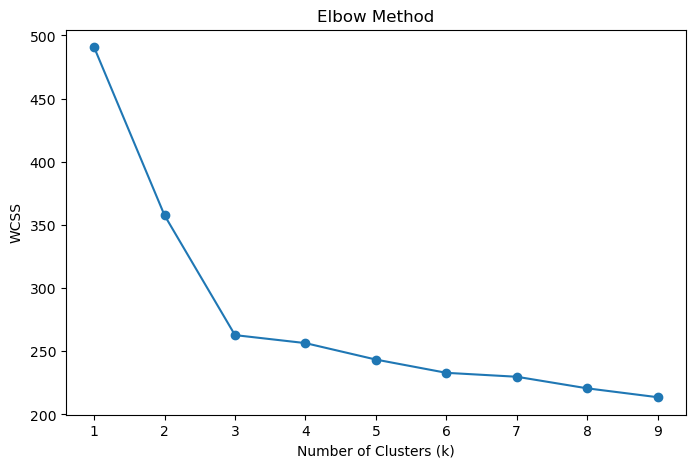

In [ ]:
plot_elbow(X, r=range(1,10))

Uit de elbow method zien we dat bij k=3 het knikpunt is. We kiezen dus voor 3 clusters.

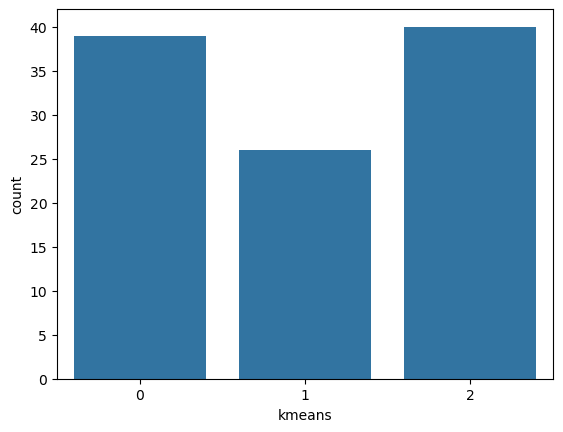

In [ ]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(X)
labels = kmeans.predict(X)
unlabeled_data['kmeans'] = labels
sns.countplot(data=unlabeled_data, x=unlabeled_data['kmeans'])
plt.show()

### Hierarchical Clustering

Hierarchical clustering is een techniek binnen unsupervised machine learning die gegevenspunten groepeert op basis van hoe vergelijkbaar ze zijn. Het resultaat is een hiërarchie van clusters, die meestal wordt weergegeven als een dendrogram. Dit toont hoe de clusters op verschillende niveaus met elkaar verbonden zijn. 
Soorten Hierarchical Clustering:

1. **Agglomeratieve clustering:** Bij deze methode begint elk gegevenspunt als een apart cluster. Vervolgens worden de meest vergelijkbare clusters stap voor stap samengevoegd, totdat uiteindelijk alle punten in één groot cluster zitten.

2. **Divisive clustering:** Hierbij begint alle data in één groot cluster. Dit cluster wordt vervolgens herhaaldelijk opgesplitst in kleinere clusters op basis van verschillen, totdat elk gegevenspunt een eigen cluster vormt.

[(Uniyal, 2024)](https://www.appliedaicourse.com/blog/hierarchical-clustering-in-machine-learning/)
[(Gupta, 2022)](https://www.scaler.com/topics/machine-learning/hierarchical-clustering/)

#### Hoe Agglomeratieve Hierarchical Clustering Werkt

Bij agglomeratieve Hierarchical clustering begint elk gegevenspunt als een eigen cluster. In elke iteratie worden de twee dichtstbijzijnde clusters samengevoegd, waarbij een vooraf gekozen afstandsmaat wordt gebruikt om de afstand tussen clusters te berekenen. Het proces gaat door totdat er nog maar één cluster overblijft of het gewenste aantal clusters is bereikt.

**Afstandsmaatstaven:**

Er worden verschillende methoden gebruikt om de afstand tussen clusters te berekenen:

- **Single linkage:** De afstand tussen de twee dichtstbijzijnde punten in verschillende clusters.
- **Complete linkage:** De afstand tussen de twee verste punten in verschillende clusters.
- **Average linkage:** De gemiddelde afstand tussen alle punten in twee verschillende clusters.
- **Ward’s methode:** Minimaliseert de variantie tussen clusters en wordt vaak gebruikt omdat het gelijkmatige clusters van vergelijkbare grootte creëert.

**Dendrogram in Hierarchical Clustering**

Een dendrogram is een boomvormig diagram dat laat zien hoe clusters worden gevormd in hierarchische clustering. Elk blad in het diagram stelt één gegevenspunt voor. Naarmate je omhoog kijkt in het diagram, zie je hoe clusters samenkomen. De hoogte waarop twee clusters worden samengevoegd geeft aan hoe verschillend of ver ze van elkaar zijn. Dit maakt het makkelijker om te begrijpen hoe de gegevens en clusters met elkaar verbonden zijn in elke stap van het proces.



**Belangrijke Verschillen tussen Divisieve Clustering en Agglomeratieve Clustering**

Divisieve clustering is complexer omdat het bij elke stap alle mogelijke manieren moet overwegen om een cluster op te splitsen, wat meer rekenkracht vereist. Deze methode is vooral geschikt voor datasets met een natuurlijke top-down hiërarchie, zoals organisatiestructuren of stambomen. Hoewel agglomeratieve clustering vaker wordt toegepast, biedt divisieve clustering waardevolle inzichten in situaties waarin een hiërarchisch overzicht van boven naar beneden belangrijk is.

[(Uniyal, 2024)](https://www.appliedaicourse.com/blog/hierarchical-clustering-in-machine-learning/)

In [ ]:
# Compute the linkage matrix
linkage_matrix = linkage(X, method='ward')

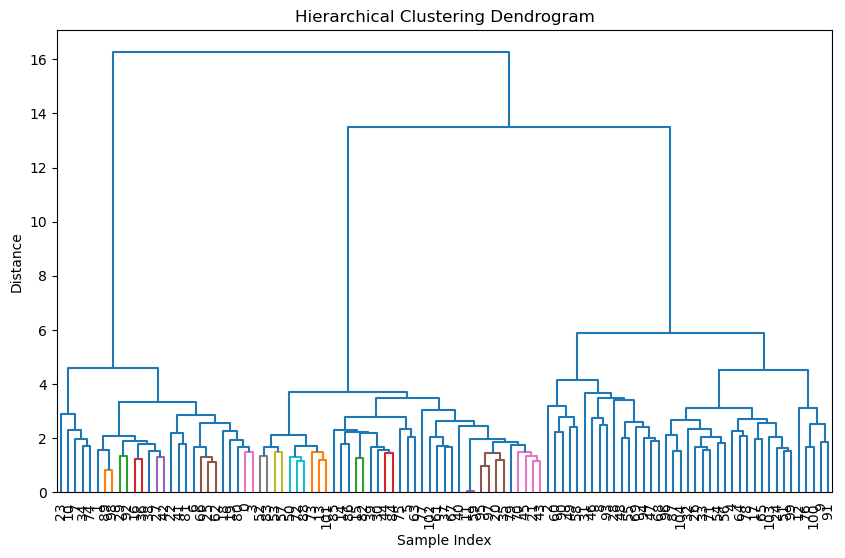

In [ ]:
plot_dendrogram(linkage_matrix)

In [ ]:
# Assign cluster labels (specify the number of clusters)
num_clusters = 3
cluster_labels = fcluster(linkage_matrix, num_clusters, criterion='maxclust')

# Add cluster labels to the DataFrame
unlabeled_data['HC'] = cluster_labels - 1 # The labels starts with 1 (1, 2, 3). -1 to have the same labels as other clusters.

### Spectral Clustering



Spectral Clustering is een krachtige techniek in machine learning die datapunten groepeert op basis van hun gelijkenis, en wordt vaak gebruikt in domeinen zoals beeldsegmentatie en sociale netwerkanalyse. De methode maakt gebruik van een graf-gebaseerde aanpak, waarbij datapunten worden behandeld als knooppunten binnen een grafiek, en de verbindingen tussen knooppunten de affiniteit tussen de datapunten vertegenwoordigen.
1. Graph-Based Approach: Spectral Clustering behandelt data als knooppunten binnen een graf, waarbij verbindingen de gelijkenis tussen de datapunten representeren.
2. Laplace Matrix: Het gebruikt de Laplace matrix (ongenormaliseerd of genormaliseerd) om de relaties tussen de datapunten te beschrijven.
3. Eigenvalue Decomposition: Spectral Clustering maakt gebruik van eigenvalue decomposition om de data in een ruimte te transformeren die betere scheiding van clusters mogelijk maakt.
4. Dimensionaliteitsreductie: De eigenvectoren verkregen uit eigenvalue decomposition kunnen worden gebruikt voor dimensionaliteitsreductie, waardoor de dataset eenvoudiger te analyseren is.
5. Clustertoewijzing: Na dimensionaliteitsreductie kunnen conventionele clusteringalgoritmen zoals K-Means of hiërarchische clustering worden toegepast om goed gedefinieerde clusters te vormen.

[(GeeksforGeeks, 2023)](https://www.geeksforgeeks.org/spectral-clustering-a-comprehensive-guide-for-beginners/)

Spectral Clustering transformeert het probleem van clusteren van de oorspronkelijke data ruimte naar een ruimte met kleinere dimensies die de inherente clusterstructuren beter weergeeft. Dit is hoe het stap voor stap werkt:  
1. **Similariteitsmatrix construeren (affiniteitsmatrix):**  
De eerste stap is het berekenen van de similariteitsmatrix $A$, waarin elk element $𝐴_{𝑖𝑗}$ de gelijkenis meet tussen datapunten $i$ en $j$. Vaak wordt hiervoor de Gaussische (radiale basisfunctie) kernel gebruikt:
$$A_{ij} = \exp\left(-\frac{\|x_{i} - x_{j}\|}{2\sigma^{2}}\right)$$  
Hier is $\sigma$, een schaalparameter die de breedte van de buurten bepaalt.

2. **Laplacian matrix construeren:**  
Op basis van de similariteitsmatrix $A$ wordt de Laplacian matrix $L$ geconstrueerd. De genormaliseerde Laplacian wordt vaak gebruikt:
$$L = D^{-1/2} AD^{-1/2}$$  
Hierin is $D$ een diagonaalmatrix met $D_{ii} = \Sigma_{j} A_{ij}$. De Laplacian matrix weerspiegelt de connectiviteit van de grafiek en legt de nadruk op zwak verbonden punten.

3. **Berekenen van eigenwaarden en eigenvectoren:**  
Bereken de eigenwaarden en eigenvectoren van de Laplacian matrix $L$. De eigenwaarden en hun bijbehorende eigenvectoren onthullen de clusters in de data. De kleinste eigenwaarden (en hun corresponderende eigenvectoren) geven inzicht in het aantal clusters door natuurlijke verdelingen of verbonden componenten in de grafiek bloot te leggen.

4. **Selecteren van de top $k$ eigenvectoren:**  
Kies de $k$ eigenvectoren die corresponderen met de kleinste niet-nul eigenwaarden. Het aantal $k$ wordt bepaald door het gewenste aantal clusters of door gebruik te maken van de eigengap-heuristiek (het analyseren van verschillen tussen opeenvolgende eigenwaarden).

5. **Kenmerkmatrix construeren:**  
Stel een matrix $X$ samen door de geselecteerde $k$ eigenvectoren kolomgewijs te combineren. Deze matrix representeert de data in een gereduceerde ruimte waarin de clusterstructuur duidelijker zichtbaar is.

6. **Normaliseren van rijen in de kenmerkmatrix:**  
Normaliseer elke rij van $X$ zodat deze een eenheidslengte heeft. Hierdoor wordt clustering uitsluitend beïnvloed door de richting van de punten in de gereduceerde ruimte, en niet door hun grootte. Dit vereenvoudigt het gebruik van afstandsgebaseerde algoritmen.

7. **Clusteren in de nieuwe kenmerkruimte:**  
Pas een standaard clusteralgoritme toe, zoals K-means, op de genormaliseerde rijen van $X$. Doordat de data nu is getransformeerd naar een ruimte waarin clusters beter te onderscheiden zijn, kunnen conventionele algoritmen effectief afzonderlijke groepen identificeren.

8. **Clusters terugvertalen naar de oorspronkelijke ruimte:**  
Wijs elk datapunt in de oorspronkelijke ruimte toe aan het cluster van zijn representatie in de gereduceerde ruimte. Dit maakt het mogelijk om de clusterresultaten te interpreteren in de context van de oorspronkelijke dataset.

[(mlres.net, 2024)](https://mlres.net/foundations-of-spectral-clustering-from-basics-to-algorithms/#:~:text=In%20summary%2C%20the%20mathematics%20behind%20spectral%20clustering%E2%80%94centered%20around,of%20the%20data%20and%20reveal%20its%20underlying%20structure.)

In [ ]:
spectral = SpectralClustering(n_clusters=3, affinity='nearest_neighbors', n_neighbors=15)
spectral_labels = spectral.fit_predict(X)
unlabeled_data['spectral'] = spectral_labels

c:\Users\henry_f4yg7pl\anaconda3\Lib\site-packages\sklearn\cluster\_spectral.py:701: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


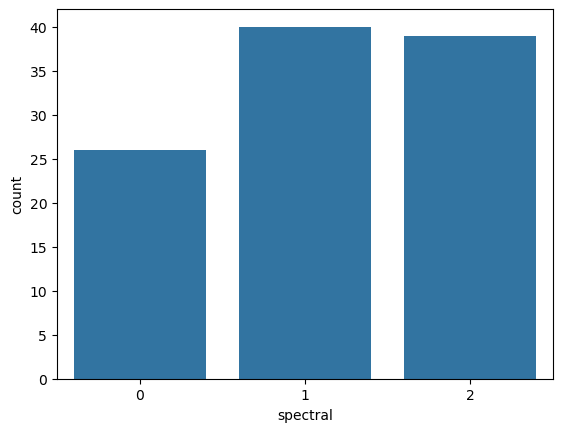

In [ ]:
sns.countplot(data=unlabeled_data, x=unlabeled_data['spectral'])
plt.show()

In [ ]:
display(unlabeled_data.head(10))

,mfccs_mean_0,mfccs_mean_1,mfccs_mean_2,mfccs_mean_3,mfccs_mean_4,mfccs_mean_5,mfccs_mean_6,mfccs_mean_7,mfccs_mean_8,mfccs_mean_9,mfccs_mean_10,mfccs_mean_11,mfccs_mean_12,mfccs_mean_13,mfccs_mean_14,mfccs_mean_15,mfccs_mean_16,mfccs_mean_17,mfccs_mean_18,mfccs_mean_19,mfccs_mean_20,mfccs_mean_21,mfccs_mean_22,mfccs_mean_23,mfccs_mean_24,mfccs_mean_25,mfccs_mean_26,mfccs_mean_27,mfccs_mean_28,mfccs_mean_29,mfccs_mean_30,mfccs_mean_31,mfccs_mean_32,mfccs_mean_33,mfccs_mean_34,mfccs_mean_35,mfccs_mean_36,mfccs_mean_37,mfccs_mean_38,mfccs_mean_39,mfccs_std_0,mfccs_std_1,mfccs_std_2,mfccs_std_3,mfccs_std_4,mfccs_std_5,mfccs_std_6,mfccs_std_7,mfccs_std_8,mfccs_std_9,mfccs_std_10,mfccs_std_11,mfccs_std_12,mfccs_std_13,mfccs_std_14,mfccs_std_15,mfccs_std_16,mfccs_std_17,mfccs_std_18,mfccs_std_19,mfccs_std_20,mfccs_std_21,mfccs_std_22,mfccs_std_23,mfccs_std_24,mfccs_std_25,mfccs_std_26,mfccs_std_27,mfccs_std_28,mfccs_std_29,mfccs_std_30,mfccs_std_31,mfccs_std_32,mfccs_std_33,mfccs_std_34,mfccs_std_35,mfccs_std_36,mfccs_std_37,mfccs_std_38,mfccs_std_39,chroma_mean_0,chroma_mean_1,chroma_mean_2,chroma_mean_3,chroma_mean_4,chroma_mean_5,chroma_mean_6,chroma_mean_7,chroma_mean_8,chroma_mean_9,chroma_mean_10,chroma_mean_11,spectral_contrast_mean_0,spectral_contrast_mean_1,spectral_contrast_mean_2,spectral_contrast_mean_3,spectral_contrast_mean_4,spectral_contrast_mean_5,spectral_contrast_mean_6,spectral_bandwidth_mean,spectral_bandwidth_std,spectral_centroid_mean,spectral_centroid_std,rolloff_mean,rolloff_std,kmeans,HC,spectral
file_name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
m00003.wav,0.146476,0.435365,0.612203,0.947481,0.107783,0.470630,0.344300,0.558401,0.856759,0.523555,0.473725,0.743222,0.692366,0.538994,0.481563,0.381877,0.478315,0.049056,0.298080,0.181456,0.636417,0.015103,0.225737,0.149234,0.260799,0.421801,0.202045,0.288100,0.141501,0.257424,0.297685,0.325065,0.055328,0.233358,0.241724,0.542486,0.330042,0.561861,0.187844,0.235862,0.178519,0.178544,0.301981,0.461824,0.216334,0.256104,0.349598,0.206947,0.203762,0.160107,0.186560,0.215978,0.243575,0.314715,0.187717,0.236906,0.268095,0.222304,0.159642,0.075043,0.132108,0.139312,0.195558,0.124269,0.118467,0.106233,0.077496,0.152105,0.195897,0.066723,0.063979,0.071727,0.077774,0.151886,0.119627,0.120851,0.119739,0.048949,0.081291,0.064222,0.762101,0.569550,0.688512,0.598373,0.560476,0.603232,0.494536,0.593540,0.614497,0.568112,0.594642,0.959556,0.282975,0.250443,0.284435,0.137085,0.118503,0.274569,0.834223,0.448643,0.218248,0.483650,0.199888,0.454474,0.226404,1,0,0
m00012.wav,0.000000,0.270143,0.583793,0.843775,0.613791,0.701388,0.533467,0.630588,0.537409,0.852664,0.693181,1.000000,0.535365,0.539048,0.695280,0.392343,0.599580,0.335220,0.348214,0.758399,0.352045,0.404409,0.148225,0.083908,0.041711,0.101434,0.315447,0.258259,0.749219,0.361731,0.099320,0.048673,0.276122,0.329374,0.346487,0.557826,0.282950,0.028130,0.083022,0.290328,0.043673,0.163460,0.244462,0.267003,0.163630,0.173855,0.320069,0.191474,0.170512,0.168116,0.138841,0.190468,0.175107,0.180056,0.169035,0.202725,0.219625,0.170689,0.217614,0.165206,0.202552,0.157376,0.212942,0.198374,0.186967,0.210496,0.142843,0.166000,0.111544,0.066176,0.093344,0.072972,0.081998,0.148397,0.164651,0.083536,0.138978,0.074508,0.121822,0.156099,0.730883,0.834570,0.984753,0.734404,0.419972,0.583531,0.456142,0.461362,0.482404,0.470372,0.350211,0.370804,0.288831,0.152515,0.295995,0.090986,0.050878,0.141317,0.892582,0.531128,0.202827,0.671364,0.174965,0.589318,0.210551,1,0,0
m00013.wav,0.519205,0.464960,0.629824,0.547061,0.420554,0.467935,0.537729,0.568458,0.250186,0.591632,0.434755,0.000000,0.658665,0.437951,0.452969,0.516353,0.466201,0.653167,0.346385,0.118235,0.414571,0.321092,0.100389,1.000000,0.288096,0.002806,0.012935,0.332102,0.628186,0.577978,1.000000,0.721534,0.367761,1.000000,0.601088,0.733841,0.111134,0.771916,1.000000,0.936510,0.434589,0.163346,0.213935,0.078523,0.333416,

In [ ]:
def scatterplot(data, x='', y='', hue=None, palette='viridis', title=''):
    '''
    A general scatterplot for this notebook's use.

    Parameters
    ----------
    data : pandas.DataFrame
        The data source for the scatterplot.
    x : str
        The name of the column to use for the x-axis.
    y : str
        The name of the column to use for the y-axis.
    hue : str, optional
        The name of the column to use for color encoding. Default is None.
    palette : str, optional
        The color palette to use. Default is 'viridis'.
    title : str, optional
        The title for the plot. Default is an empty string.

    Returns
    -------
    None
        Displays the scatterplot.
    '''
    sns.scatterplot(data=data, x=x, y=y, hue=hue, palette=palette)
    plt.title(title)
    plt.xlabel(f'{x}')
    plt.ylabel(f'{y}')
    plt.legend(title=hue, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

def compare_labels(labeled_data, unlabeled_data, labeled_target='genre', x='', y='', labeled_hue='genre', unlabeled_hue='kmeans'):
    '''
    Compare scatterplots of labeled and unlabeled data based on specified features.

    Parameters
    ----------
    labeled_data : pandas.DataFrame
        The labeled dataset containing a target column.
    unlabeled_data : pandas.DataFrame
        The unlabeled dataset to compare against.
    labeled_target : str, optional
        The column name in the labeled dataset representing the target variable. Default is 'genre'.
    x : str
        The name of the column to use for the x-axis.
    y : str
        The name of the column to use for the y-axis.
    labeled_hue : str, optional
        The column name in the labeled dataset for color encoding. Default is 'genre'.
    unlabeled_hue : str, optional
        The column name in the unlabeled dataset for color encoding. Default is 'kmeans'.

    Returns
    -------
    None
        Displays the scatterplots for each genre and the corresponding clusters.
    '''
    genres = set(labeled_data[labeled_target])

    rows = int(len(genres) / 2)
    fig, axes = plt.subplots(nrows=rows, ncols=2, figsize=(15, 25))
    axes = axes.flatten()

    # Plot each genre
    for i, genre in enumerate(genres):
        genre_data = labeled_data[labeled_data['genre'] == genre]
        
        # Scatterplot for the specific genre
        sns.scatterplot(data=genre_data, x=x, y=y, hue=labeled_hue, marker='o', s=100, edgecolor='black', ax=axes[i])
        
        # Scatterplot for clusters
        sns.scatterplot(data=unlabeled_data, x=x, y=y, hue=unlabeled_hue, palette='viridis', marker='x', s=50, ax=axes[i])
        
        axes[i].set_title(f'Scatterplot of {genre.capitalize()} Genre and Clusters')
        axes[i].set_xlabel(f'{x}')
        axes[i].set_ylabel(f'{y}')

    # Adjust layout
    plt.tight_layout()
    plt.show()

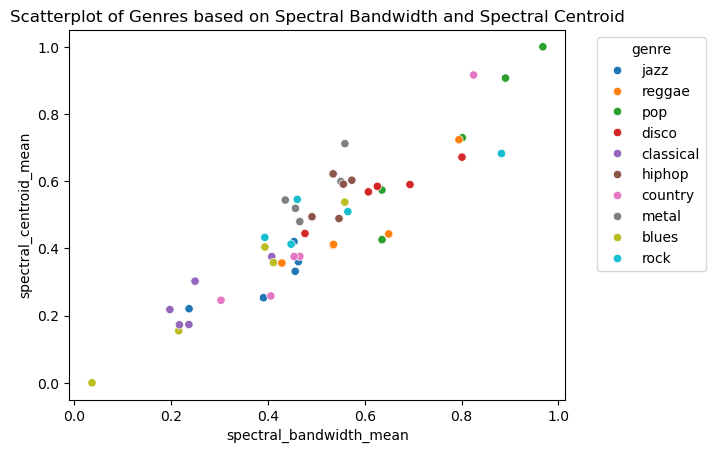

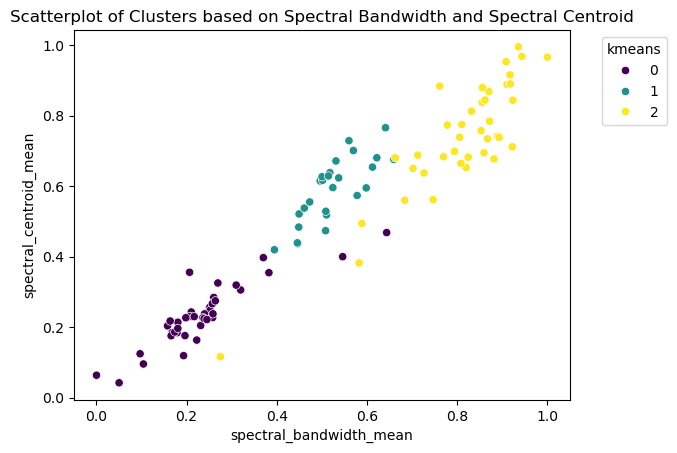

In [ ]:
scatterplot(data=labeled_data, x='spectral_bandwidth_mean', y='spectral_centroid_mean', hue='genre', palette=None, title='Scatterplot of Genres based on Spectral Bandwidth and Spectral Centroid')
scatterplot(data=unlabeled_data, x='spectral_bandwidth_mean', y='spectral_centroid_mean', hue='kmeans', title='Scatterplot of Clusters based on Spectral Bandwidth and Spectral Centroid')

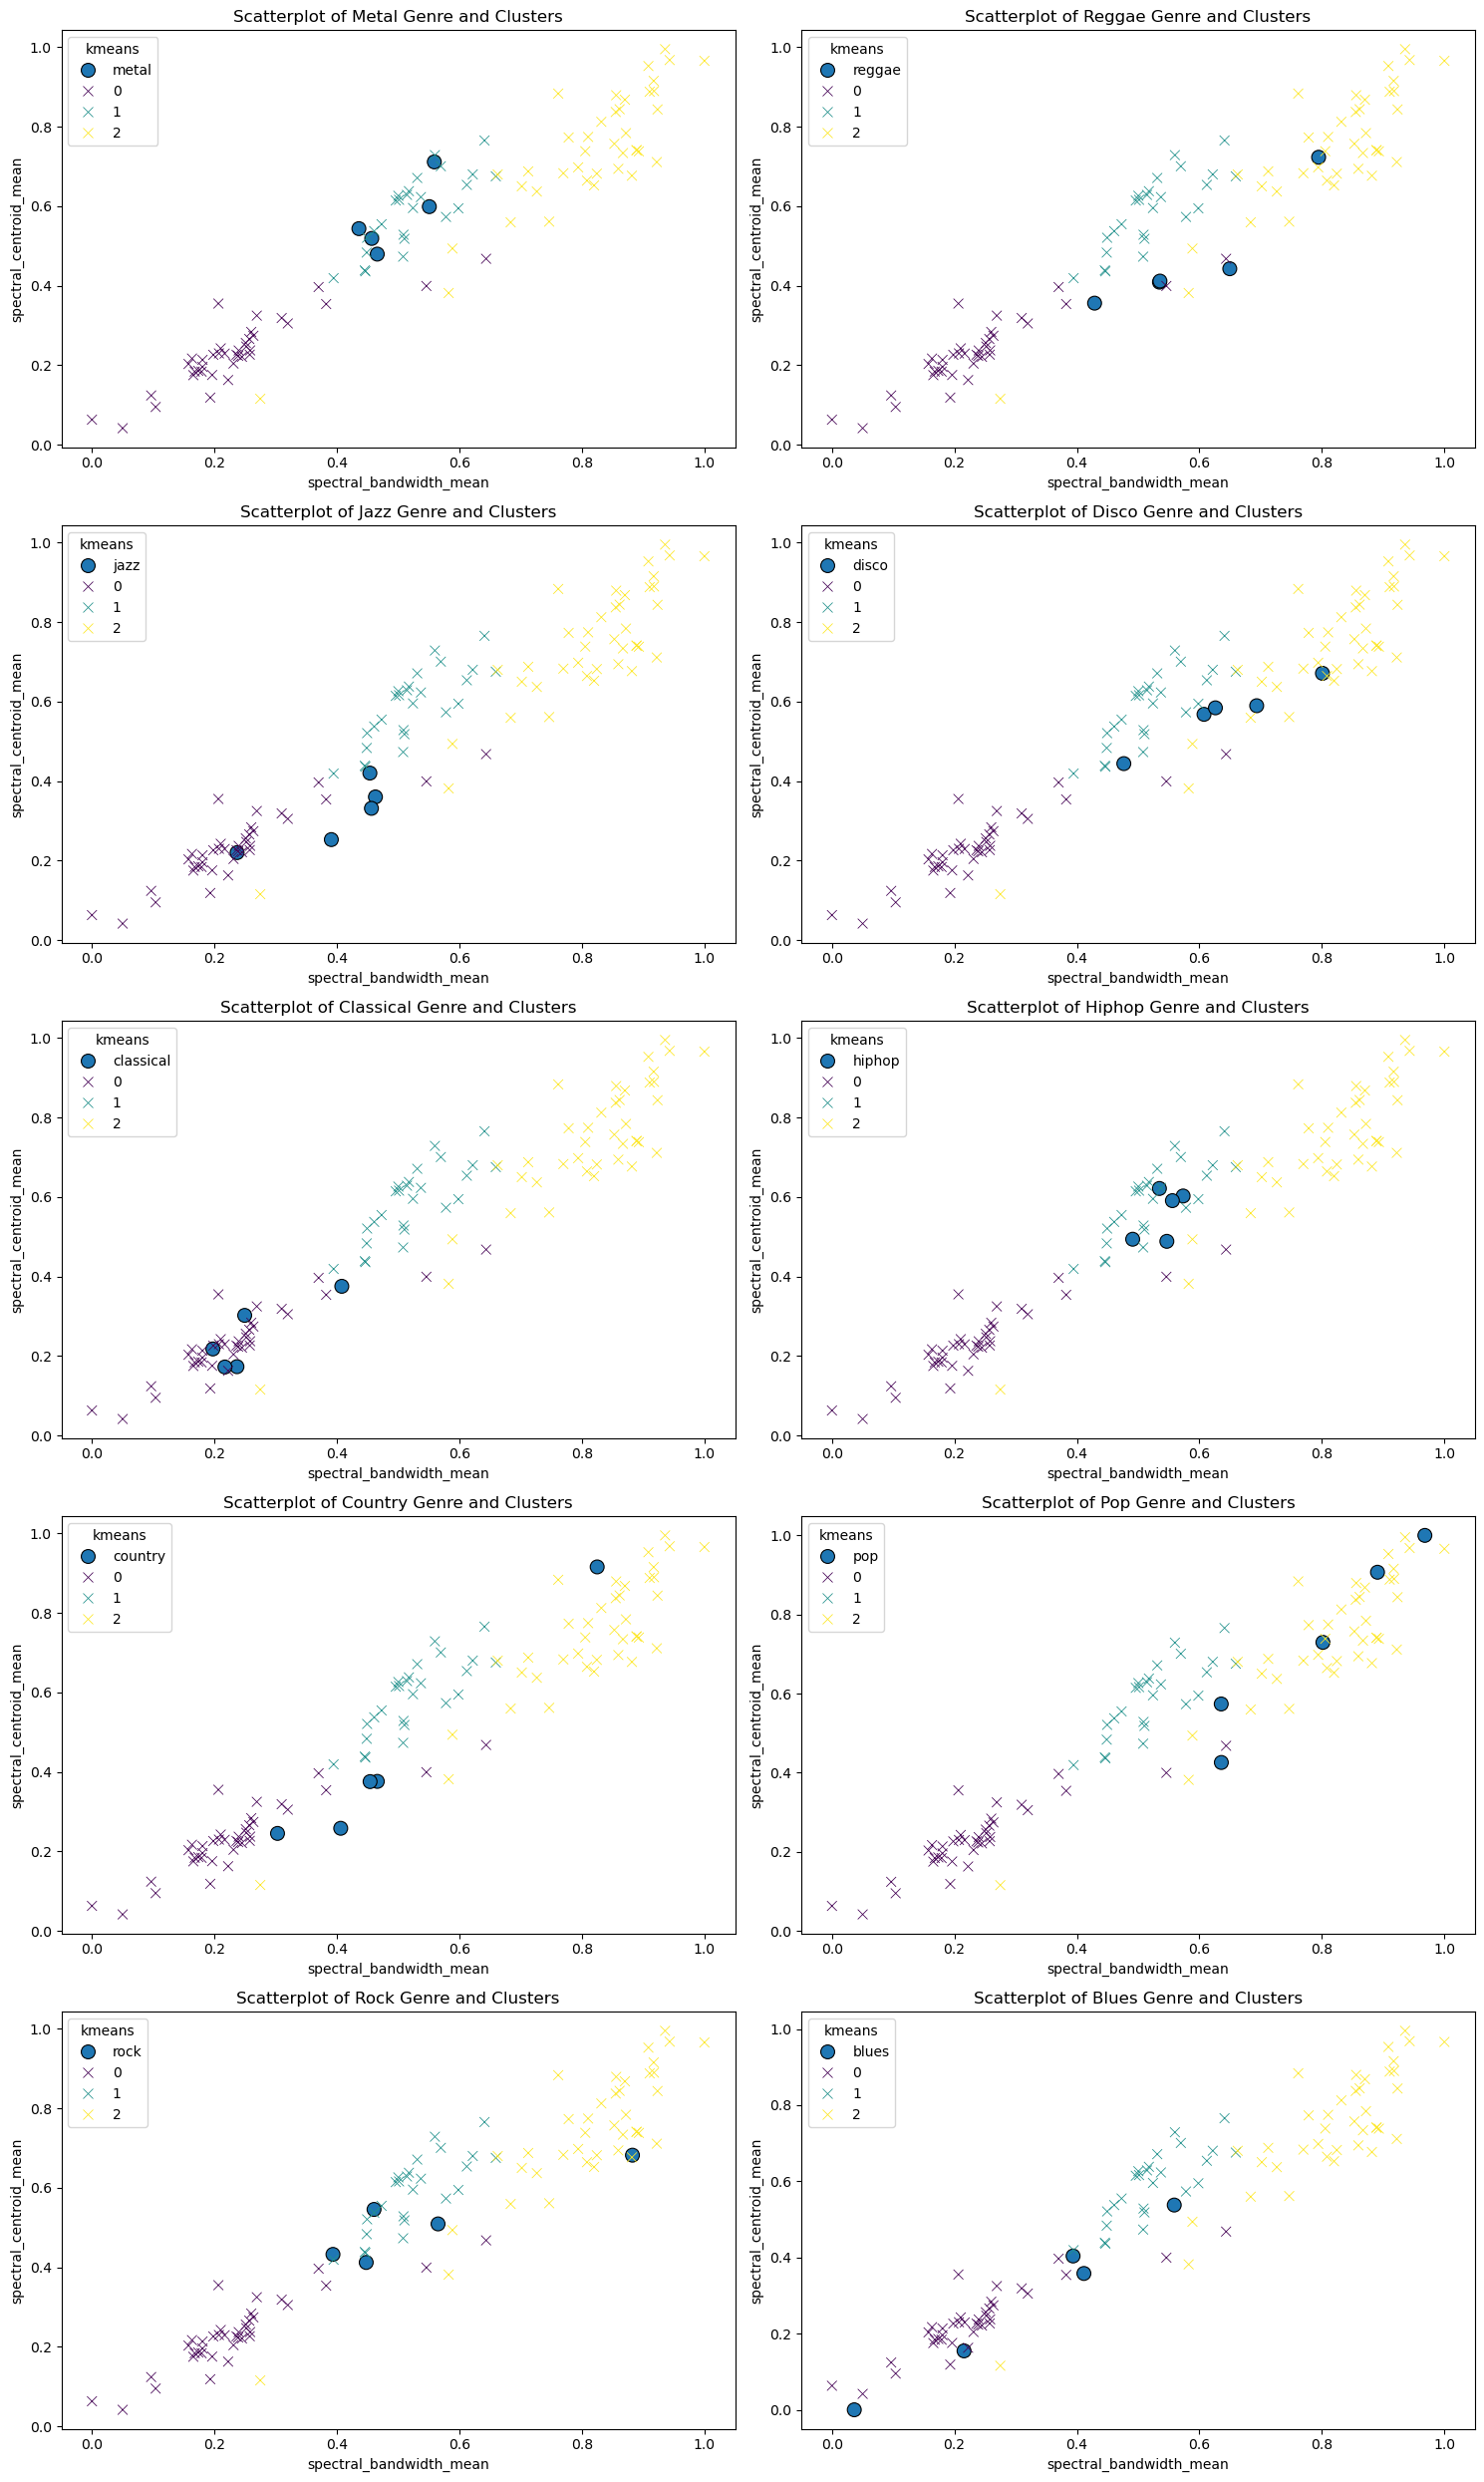

In [ ]:
compare_labels(labeled_data, unlabeled_data, x='spectral_bandwidth_mean', y='spectral_centroid_mean', labeled_hue='genre', unlabeled_hue='kmeans')

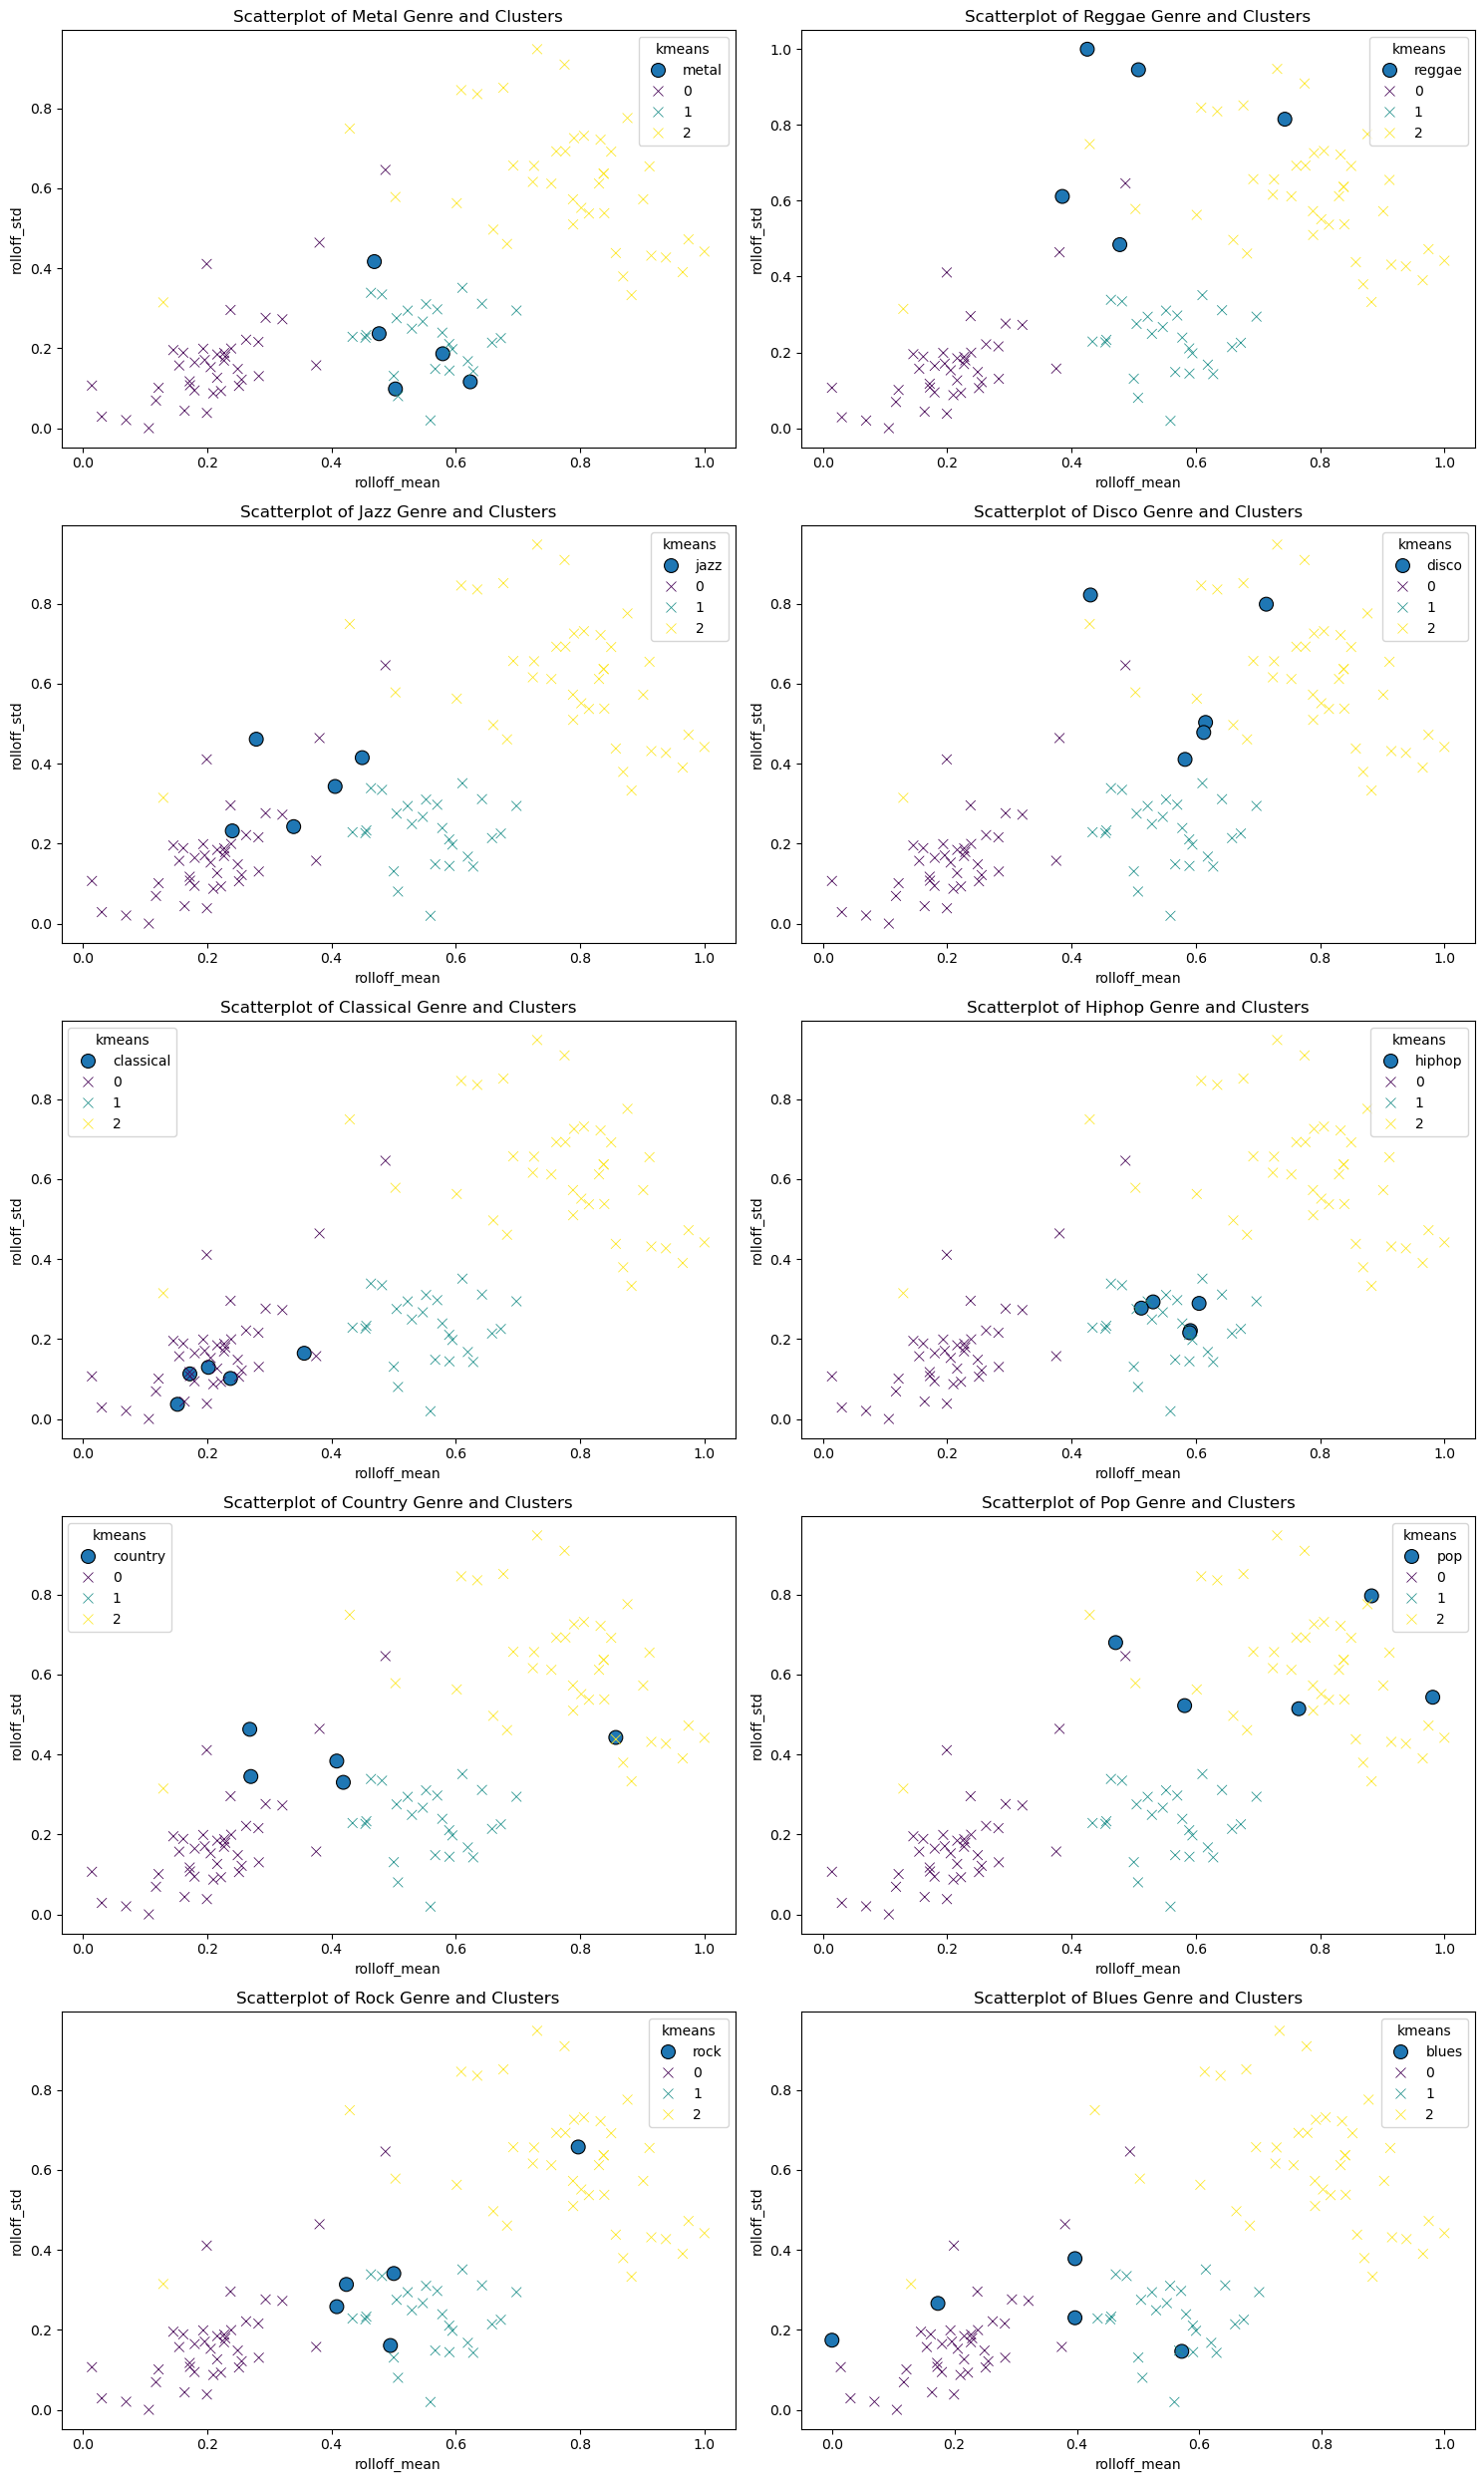

In [ ]:
compare_labels(labeled_data, unlabeled_data, x='rolloff_mean', y='rolloff_std', labeled_hue='genre', unlabeled_hue='kmeans')

|kmeans|Label|
|------|-----|
|0     |classical|
|1     |metal|
|2     |pop|

Bij de scatterplots zien we dat twee van onze clusters pop en classical zijn. Bij de laatste cluster krijgen we twee genres (Metal/HipHop). Om te weten welke genre het is gaan we kaggle score gebruiken om te zien welke het eigenlijk is. Voor HipHop krijgen we een score van $0.77$ en met Metal een score van $0.96$. Dus de 3 clusters zijn metal, pop en classical.

In [ ]:
genre_mapping = {0: 'classical', 1: 'metal', 2: 'pop'}
unlabeled_data['genre'] = unlabeled_data['kmeans'].map(genre_mapping)
display(unlabeled_data.head(10))

,mfccs_mean_0,mfccs_mean_1,mfccs_mean_2,mfccs_mean_3,mfccs_mean_4,mfccs_mean_5,mfccs_mean_6,mfccs_mean_7,mfccs_mean_8,mfccs_mean_9,mfccs_mean_10,mfccs_mean_11,mfccs_mean_12,mfccs_mean_13,mfccs_mean_14,mfccs_mean_15,mfccs_mean_16,mfccs_mean_17,mfccs_mean_18,mfccs_mean_19,mfccs_mean_20,mfccs_mean_21,mfccs_mean_22,mfccs_mean_23,mfccs_mean_24,mfccs_mean_25,mfccs_mean_26,mfccs_mean_27,mfccs_mean_28,mfccs_mean_29,mfccs_mean_30,mfccs_mean_31,mfccs_mean_32,mfccs_mean_33,mfccs_mean_34,mfccs_mean_35,mfccs_mean_36,mfccs_mean_37,mfccs_mean_38,mfccs_mean_39,mfccs_std_0,mfccs_std_1,mfccs_std_2,mfccs_std_3,mfccs_std_4,mfccs_std_5,mfccs_std_6,mfccs_std_7,mfccs_std_8,mfccs_std_9,mfccs_std_10,mfccs_std_11,mfccs_std_12,mfccs_std_13,mfccs_std_14,mfccs_std_15,mfccs_std_16,mfccs_std_17,mfccs_std_18,mfccs_std_19,mfccs_std_20,mfccs_std_21,mfccs_std_22,mfccs_std_23,mfccs_std_24,mfccs_std_25,mfccs_std_26,mfccs_std_27,mfccs_std_28,mfccs_std_29,mfccs_std_30,mfccs_std_31,mfccs_std_32,mfccs_std_33,mfccs_std_34,mfccs_std_35,mfccs_std_36,mfccs_std_37,mfccs_std_38,mfccs_std_39,chroma_mean_0,chroma_mean_1,chroma_mean_2,chroma_mean_3,chroma_mean_4,chroma_mean_5,chroma_mean_6,chroma_mean_7,chroma_mean_8,chroma_mean_9,chroma_mean_10,chroma_mean_11,spectral_contrast_mean_0,spectral_contrast_mean_1,spectral_contrast_mean_2,spectral_contrast_mean_3,spectral_contrast_mean_4,spectral_contrast_mean_5,spectral_contrast_mean_6,spectral_bandwidth_mean,spectral_bandwidth_std,spectral_centroid_mean,spectral_centroid_std,rolloff_mean,rolloff_std,kmeans,HC,spectral,genre
file_name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
m00003.wav,0.146476,0.435365,0.612203,0.947481,0.107783,0.470630,0.344300,0.558401,0.856759,0.523555,0.473725,0.743222,0.692366,0.538994,0.481563,0.381877,0.478315,0.049056,0.298080,0.181456,0.636417,0.015103,0.225737,0.149234,0.260799,0.421801,0.202045,0.288100,0.141501,0.257424,0.297685,0.325065,0.055328,0.233358,0.241724,0.542486,0.330042,0.561861,0.187844,0.235862,0.178519,0.178544,0.301981,0.461824,0.216334,0.256104,0.349598,0.206947,0.203762,0.160107,0.186560,0.215978,0.243575,0.314715,0.187717,0.236906,0.268095,0.222304,0.159642,0.075043,0.132108,0.139312,0.195558,0.124269,0.118467,0.106233,0.077496,0.152105,0.195897,0.066723,0.063979,0.071727,0.077774,0.151886,0.119627,0.120851,0.119739,0.048949,0.081291,0.064222,0.762101,0.569550,0.688512,0.598373,0.560476,0.603232,0.494536,0.593540,0.614497,0.568112,0.594642,0.959556,0.282975,0.250443,0.284435,0.137085,0.118503,0.274569,0.834223,0.448643,0.218248,0.483650,0.199888,0.454474,0.226404,1,0,0,metal
m00012.wav,0.000000,0.270143,0.583793,0.843775,0.613791,0.701388,0.533467,0.630588,0.537409,0.852664,0.693181,1.000000,0.535365,0.539048,0.695280,0.392343,0.599580,0.335220,0.348214,0.758399,0.352045,0.404409,0.148225,0.083908,0.041711,0.101434,0.315447,0.258259,0.749219,0.361731,0.099320,0.048673,0.276122,0.329374,0.346487,0.557826,0.282950,0.028130,0.083022,0.290328,0.043673,0.163460,0.244462,0.267003,0.163630,0.173855,0.320069,0.191474,0.170512,0.168116,0.138841,0.190468,0.175107,0.180056,0.169035,0.202725,0.219625,0.170689,0.217614,0.165206,0.202552,0.157376,0.212942,0.198374,0.186967,0.210496,0.142843,0.166000,0.111544,0.066176,0.093344,0.072972,0.081998,0.148397,0.164651,0.083536,0.138978,0.074508,0.121822,0.156099,0.730883,0.834570,0.984753,0.734404,0.419972,0.583531,0.456142,0.461362,0.482404,0.470372,0.350211,0.370804,0.288831,0.152515,0.295995,0.090986,0.050878,0.141317,0.892582,0.531128,0.202827,0.671364,0.174965,0.589318,0.210551,1,0,0,metal
m00013.wav,0.519205,0.464960,0.629824,0.547061,0.420554,0.467935,0.537729,0.568458,0.250186,0.591632,0.434755,0.000000,0.658665,0.437951,0.452969,0.516353,0.466201,0.653167,0.346385,0.118235,0.414571,0.321092,0.100389,1.000000,0.288096,0.002806,0.012935,0.332102,0.628186,0.577978,1.000000,0.721534,0.367761,1.000000,0.601088,0.733841,0.111134,0.771916,1.000000,0.936510,0.434589,0.163346,0.213935

### Principal Component Analysis (PCA)

#### Wiskundige werking van PCA

PCA is een lineaire techniek voor dimensiereductie die gebruikmaakt van een wiskundige transformatie om een dataset met hoge dimensies te projecteren op een lager-dimensionale ruimte. Het doel is om zoveel mogelijk variatie (informatie) in de data te behouden. Hieronder worden de stappen van PCA uitgelegd.

##### **1. Standaardisatie van de data**

De dataset wordt eerst geschaald zodat elke feature een gemiddelde van 0 en een standaardafwijking van 1 heeft. Dit gebeurt met de volgende formule:

$$
x' = \frac{x - \bar{x}}{\sigma}
$$

##### Waarbij:
- \( $x$ \): De waarde van een specifieke feature in de dataset (een datawaarde).
- \( $\bar{x}$ \): Het gemiddelde van alle waarden van die specifieke feature.
- \( $\sigma$ \): De standaardafwijking van die specifieke feature.
- \( $x'$ \): De gestandaardiseerde waarde (met gemiddelde 0 en standaardafwijking 1).

##### **2. Berekening van de covariantiematrix**

De covariantiematrix meet de variabiliteit tussen de verschillende features. Deze wordt berekend met de formule:

$$
\Sigma = \frac{1}{n-1} X^T X
$$

##### Waarbij:
- \( $\Sigma$ \): De **covariantiematrix**, een vierkante matrix waarin elke cel de covariantie tussen twee features \( x_i \) en \( x_j \) weergeeft.
- \( $X$ \): De data **matrix** na standaardisatie. Elke rij vertegenwoordigt een datapuntenvector, en elke kolom stelt een gestandaardiseerde feature voor.
- \( $X^T$ \): De getransponeerde matrix van \( X \), waarin de rijen en kolommen zijn omgewisseld.
- \( $n$ \): Het aantal datapunten in de dataset.
- \( $n-1$ \): Correctiefactor die rekening houdt met het aantal vrijheidsgraden bij het berekenen van de covariantie.

##### **3. Eigenwaarden en eigenvectoren**

Voor de covariantiematrix \( $\Sigma$ \) worden de eigenwaarden en eigenvectoren berekend. Deze voldoen aan de volgende eigenschap:

$$
\Sigma v = \lambda v
$$

##### Waarbij:
- \( $\lambda$ \): Een **eigenwaarde**, die de hoeveelheid variatie aangeeft die door de corresponderende eigenvector wordt uitgelegd.
- \( $v$ \): Een **eigenvector**, die de richting van maximale variatie in de data weergeeft.
- \( $\Sigma$ \): De covariantiematrix.

De eigenwaarden en eigenvectoren worden gebruikt om de belangrijkste componenten te bepalen.

##### **4. Selectie van belangrijkste componenten**

De eigenvectoren worden gerangschikt op basis van hun bijbehorende eigenwaarden \( $\lambda$ \). Alleen de top \( $k$ \) eigenvectoren met de hoogste eigenwaarden worden geselecteerd. Dit bepaalt de nieuwe dimensie \( $k$ \).

- \( $k$ \): Het aantal dimensies dat overblijft na dimensiereductie. Dit wordt gekozen door de gebruiker, afhankelijk van hoeveel variatie behouden moet blijven.

##### **5. Transformatie naar de lagere dimensie**

Na selectie van de belangrijkste eigenvectoren wordt de originele data getransformeerd naar de lagere dimensie. De transformatie is als volgt:

$$
Z = X W
$$

##### Waarbij:
- \( $Z$ \): De getransformeerde data in de lagere-dimensionale ruimte. Elke rij is een datapuntenvector in deze nieuwe \( $k$ \)-dimensionale ruimte.
- \( $X$ \): De gestandaardiseerde data matrix.
- \( $W$ \): De matrix bestaande uit de geselecteerde \( $k$ \) eigenvectoren (elk als een kolom).

Hierbij projecteert \( $W$ \) de originele data \( $X$ \) op de ruimte die wordt gedefinieerd door de \( $k$ \) belangrijkste eigenvectoren.

# Bronnen

Wikipedia contributors. (2024, 12 december). Principal Component Analysis. Wikipedia. https://en.wikipedia.org/wiki/Principal_component_analysis

GeeksforGeeks. (2024, 17 september). Principal Component Analysis (PCA). GeeksforGeeks. https://www.geeksforgeeks.org/principal-component-analysis-pca/


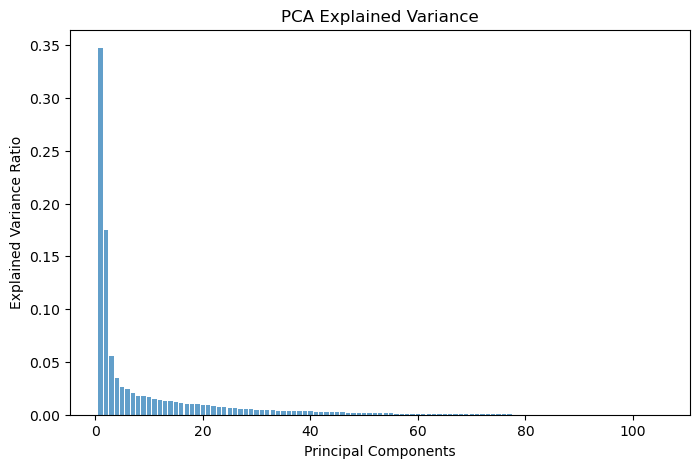

In [ ]:
pca = PCA()

# Fit PCA on the data
pca.fit(X)

# Explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

plt.figure(figsize=(8,5))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.7)
plt.title('PCA Explained Variance')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.show()

In [ ]:
# PCA on labeled data
pca = PCA(n_components=2)
pca_results = pca.fit_transform(labeled_data.drop('genre', axis=1))
pca_labeled = pd.DataFrame(pca_results, columns=['PC1', 'PC2'], index=labeled_data.index)
pca_labeled = pca_labeled.merge(labeled_data['genre'], left_index=True, right_index=True)

# PCA on unlabeled data
pca = PCA(n_components=2)
pca_results = pca.fit_transform(X)
pca_df = pd.DataFrame(pca_results, columns=['PC1', 'PC2'], index=X.index)

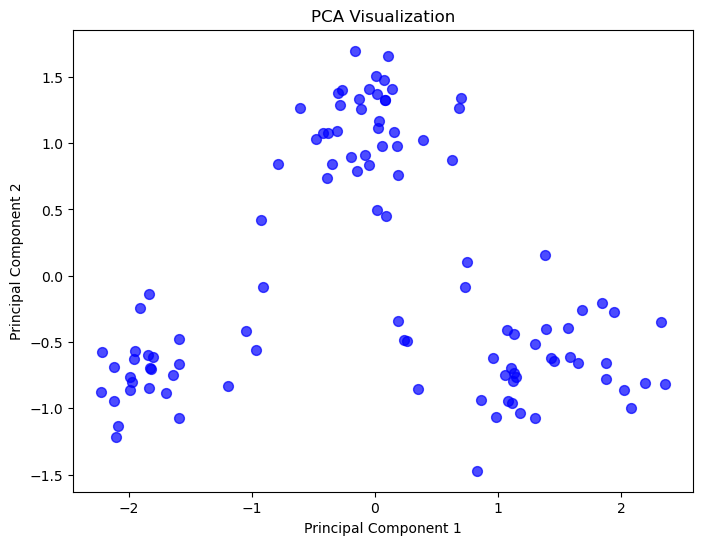

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(pca_df['PC1'], pca_df['PC2'], c='blue', s=50, alpha=0.7)
plt.title('PCA Visualization')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [ ]:
X_pca = pca_df.copy()

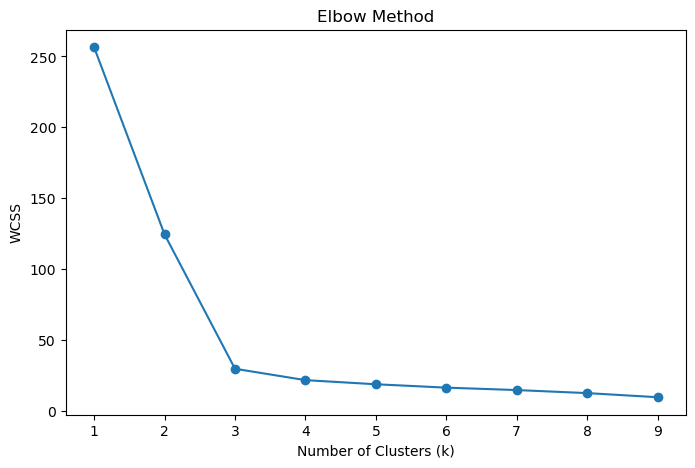

In [ ]:
plot_elbow(X_pca, r=range(1,10))

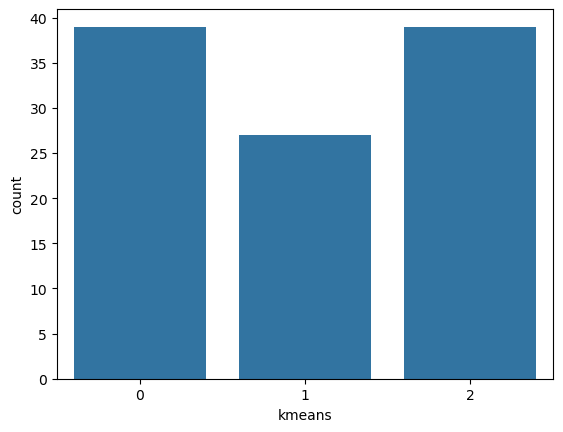

In [ ]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(X_pca)
labels = kmeans.predict(X_pca)
pca_df['kmeans'] = labels
sns.countplot(data=pca_df, x=pca_df['kmeans'])
plt.show()

In [ ]:
# Compute the linkage matrix
linkage_matrix = linkage(X_pca, method='ward')

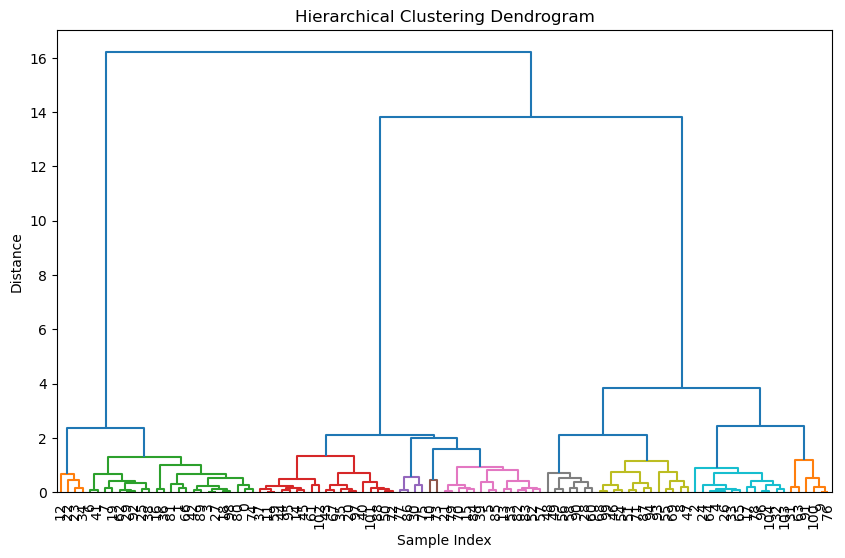

In [ ]:
plot_dendrogram(linkage_matrix)

In [ ]:
# Assign cluster labels (specify the number of clusters)
num_clusters = 3
cluster_labels = fcluster(linkage_matrix, num_clusters, criterion='maxclust')

# Add cluster labels to the DataFrame
pca_df['HC'] = cluster_labels - 1
print(pca_df)

                 PC1       PC2  kmeans  HC
file_name                                 
m00003.wav -1.643427 -0.752010       1   0
m00012.wav -1.836929 -0.845970       1   0
m00013.wav  0.831246 -1.470875       0   2
m00043.wav -1.828477 -0.692455       1   0
m00044.wav  1.145247 -0.760323       0   2
...              ...       ...     ...  ..
m00971.wav  0.184869 -0.340600       0   2
m00973.wav -0.480723  1.028487       2   1
m00988.wav  0.108839  1.654352       2   1
m00991.wav  1.181054 -1.036958       0   2
m00995.wav  1.085624 -0.945893       0   2

[105 rows x 4 columns]


In [ ]:
spectral = SpectralClustering(n_clusters=3, affinity='nearest_neighbors', n_neighbors=15)
spectral_labels = spectral.fit_predict(X_pca)
pca_df['spectral'] = spectral_labels

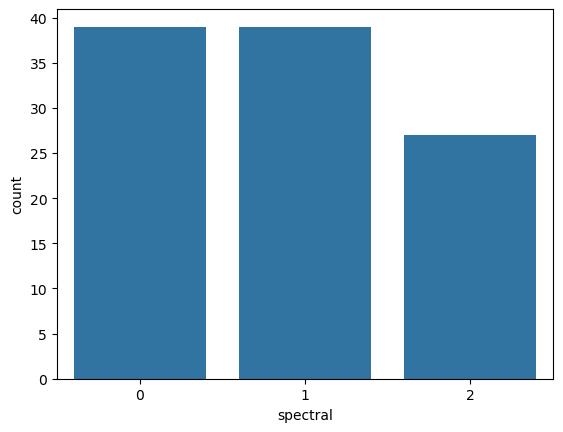

In [ ]:
sns.countplot(data=pca_df, x=pca_df['spectral'])
plt.show()

In [ ]:
display(pca_df)

,PC1,PC2,kmeans,HC,spectral
file_name,,,,,
m00003.wav,-1.643427,-0.752010,1,0,2
m00012.wav,-1.836929,-0.845970,1,0,2
m00013.wav,0.831246,-1.470875,0,2,1
m00043.wav,-1.828477,-0.692455,1,0,2
m00044.wav,1.145247,-0.760323,0,2,1
...,...,...,...,...,...
m00971.wav,0.184869,-0.340600,0,2,1
m00973.wav,-0.480723,1.028487,2,1,0
m00988.wav,0.108839,1.654352,2,1,0


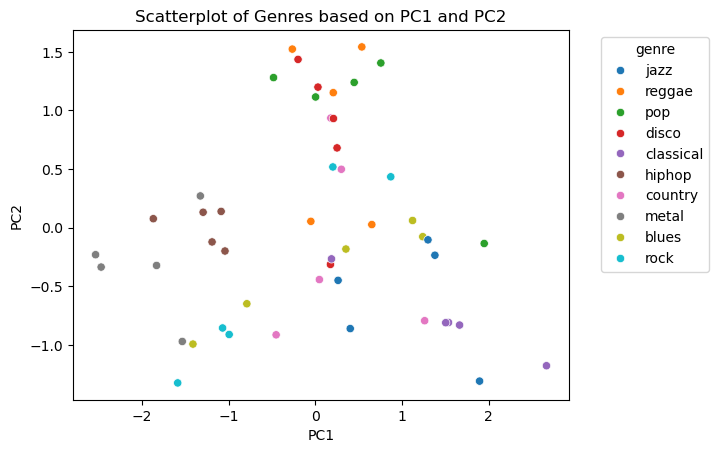

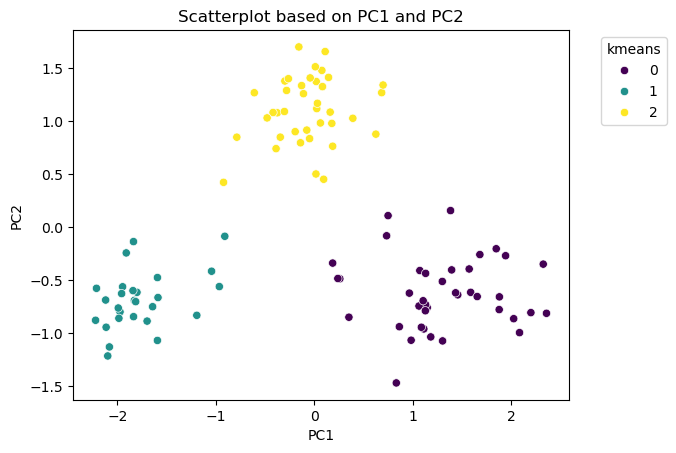

In [ ]:
scatterplot(data=pca_labeled, x='PC1', y='PC2', hue='genre', palette=None, title='Scatterplot of Genres based on PC1 and PC2')
scatterplot(data=pca_df, x='PC1', y='PC2', hue='kmeans', title='Scatterplot based on PC1 and PC2')

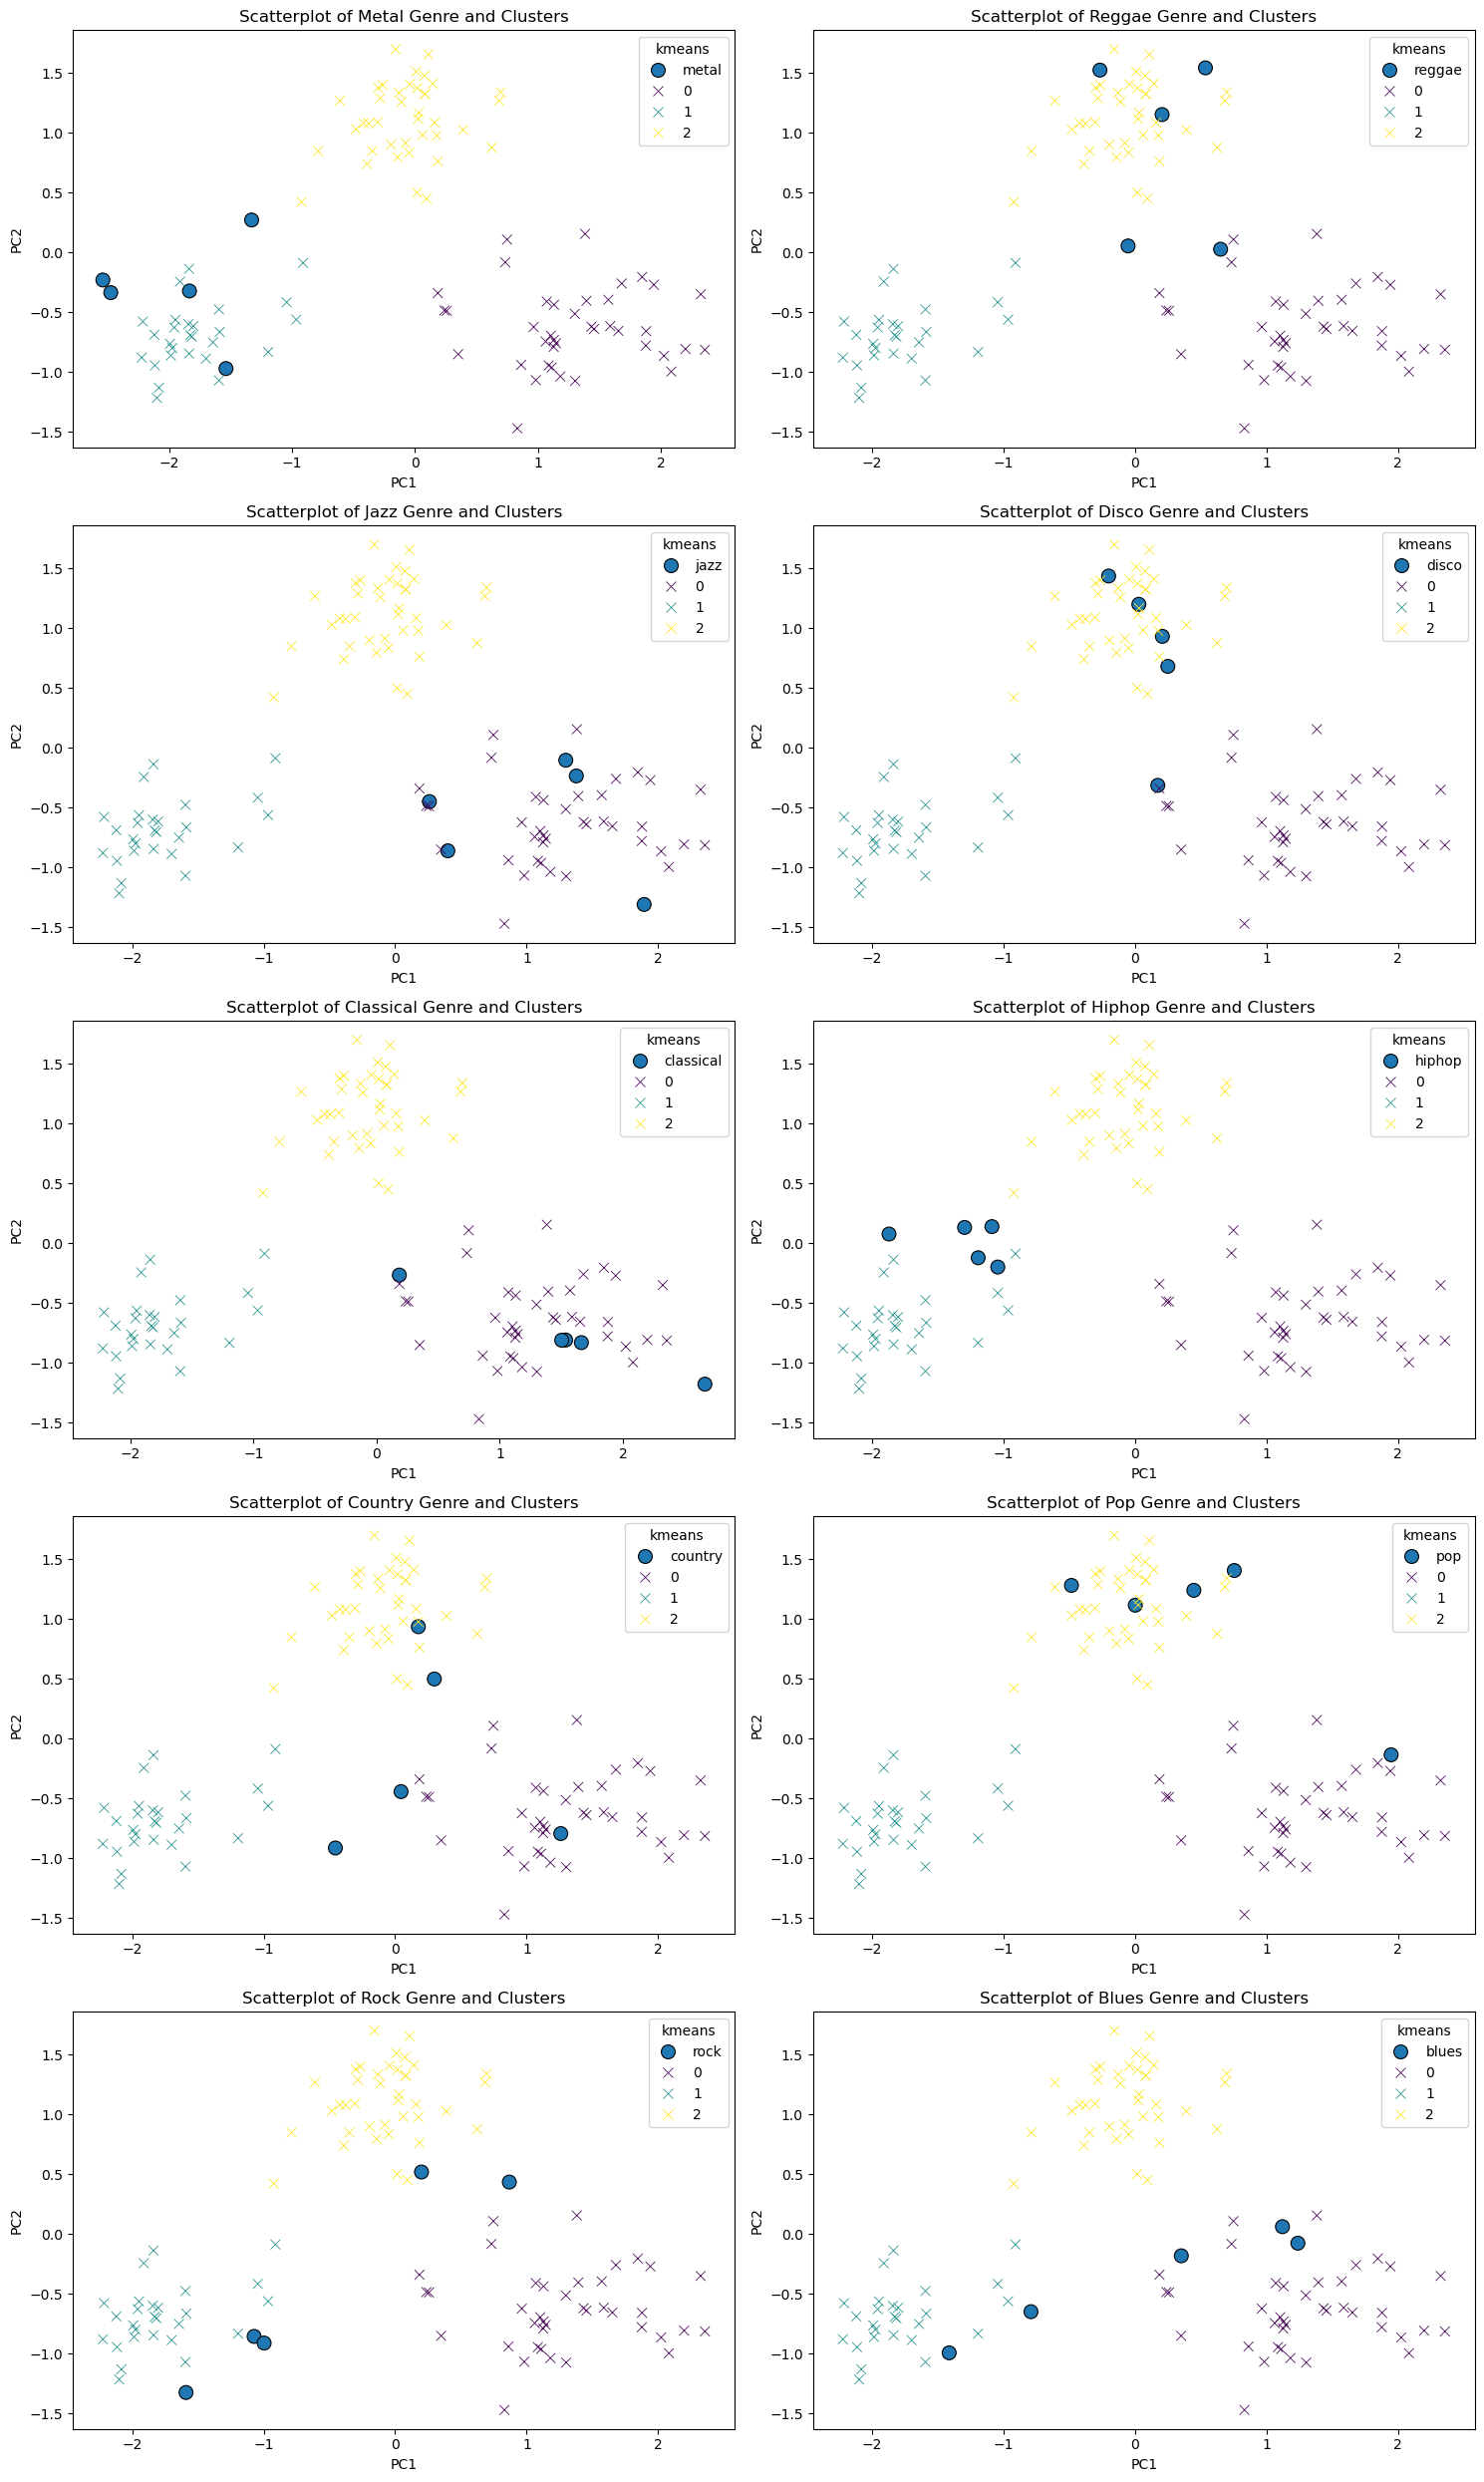

In [ ]:
compare_labels(labeled_data=pca_labeled, unlabeled_data=pca_df, x='PC1', y='PC2')

|kmeans|Label|
|------|-----|
|0     |Classical|
|1     |Metal|
|2     |Pop|

In [ ]:
genre_mapping = {0: 'classical', 1: 'metal', 2: 'pop'}
pca_df['genre'] = pca_df['kmeans'].map(genre_mapping)
display(pca_df.head(10))

,PC1,PC2,kmeans,HC,spectral,genre
file_name,,,,,,
m00003.wav,-1.643427,-0.752010,1,0,2,metal
m00012.wav,-1.836929,-0.845970,1,0,2,metal
m00013.wav,0.831246,-1.470875,0,2,1,classical
m00043.wav,-1.828477,-0.692455,1,0,2,metal
m00044.wav,1.145247,-0.760323,0,2,1,classical
m00055.wav,0.015274,0.499649,2,1,0,pop
m00061.wav,-2.082150,-1.131371,1,0,2,metal
m00063.wav,-2.213373,-0.578585,1,0,2,metal
m00069.wav,1.571191,-0.396264,0,2,1,classical


### Non-negatieve Matrixfactorisatie (NMF)

#### Wiskundige werking van NMF

Non-negatieve Matrixfactorisatie (NMF) is een techniek voor dimensiereductie die een niet-negatieve matrix \( $V$ \) ontleedt in twee niet-negatieve matrices \( $W$ \) en \( $H$ \). Het doel is om de oorspronkelijke data te benaderen door de productmatrix \( $WH$ \), waarbij alle elementen niet-negatief zijn. Dit is vooral nuttig in toepassingen waar de gegevens van nature niet-negatief zijn, zoals bij afbeeldingen, audio en tekstgegevens. 


##### **1. Factorisatie van de matrix**

NMF probeert de matrix \( $V$ \) te factoriseren in twee matrices \( $W$ \) en \( $H$ \) zodanig dat:

$$
V \approx WH
$$

**Betekenis van de symbolen:**
- \( $V$ \): De oorspronkelijke niet-negatieve data matrix van dimensie \( $m \times n$ \).
- \( $W$ \): Een niet-negatieve matrix van dimensie \( $m \times k$ \), waarbij elke kolom een basisvector vertegenwoordigt.
- \( $H$ \): Een niet-negatieve matrix van dimensie \( $k \times n$ \), waarbij elke rij de coëfficiënten bevat voor de lineaire combinatie van basisvectoren om de kolommen van \( $V$ \) te benaderen.
- \( $k$ \): Het aantal latente componenten of basisvectoren, gekozen op basis van de gewenste reductie en interpretatie.


##### **2. Optimalisatieprobleem**

Het doel is om \( $W$ \) en \( $H$ \) te vinden die de reconstructiefout minimaliseren. Een veelgebruikte maat voor deze fout is de Frobeniusnorm van het verschil tussen \( $V$ \) en \( $WH$ \):

$$
\min_{W, H} \| V - WH \|_F^2
$$

**Onder de voorwaarden:**
- \( $W \geq 0$ \)
- \( $H \geq 0$ \)

Hierbij zorgt de niet-negativiteitsbeperking ervoor dat de resulterende matrices \( $W$ \) en \( $H$ \) geen negatieve elementen bevatten, wat bijdraagt aan de interpretatie van de componenten. 


##### **3. Iteratieve update-algoritmen**

Er zijn verschillende algoritmen ontwikkeld om \( $W$ \) en \( $H$ \) iteratief bij te werken om de reconstructiefout te minimaliseren. Een bekende benadering is het gebruik van multiplicatieve update-regels,  

De update-regels zijn als volgt:

$$
H_{ij} \leftarrow H_{ij} \frac{(W^T V)_{ij}}{(W^T W H)_{ij}}
$$

$$
W_{ij} \leftarrow W_{ij} \frac{(V H^T)_{ij}}{(W H H^T)_{ij}}
$$

Deze regels worden herhaald totdat de reconstructiefout convergeert naar een minimumwaarde. 



# Bronnen
Wikipedia contributors. (2024, 12 december). Non-negative Matrix Factorization. Wikipedia. https://en.wikipedia.org/wiki/Non-negative_matrix_factorization

Lee, D. D., & Seung, H. S. (2001). Algorithms for Non-negative Matrix Factorization. Advances in Neural Information Processing Systems, 13, 556–562. https://proceedings.neurips.cc/paper/1861-algorithms-for-non-negative-matrix-factorization.pdf

\GeeksforGeeks. (2024, 17 september). Introduction to Non-negative Matrix Factorization. GeeksforGeeks. https://www.geeksforgeeks.org/introduction-to-non-negative-matrix-factorization/


In [ ]:
# NMF unlabeled
nmf = NMF(n_components=2, random_state=42, max_iter=1000)
nmf.fit(X)
nmf_features_unlab = nmf.transform(X)
nmf_df = pd.DataFrame(nmf_features_unlab, columns=['NMF1', 'NMF2'], index=X.index)

# NMF labeled
nmf_features_lab = nmf.transform(labeled_data)
nmf_labeled = pd.DataFrame(nmf_features_lab, columns=['NMF1','NMF2'], index=labeled_data.index)
nmf_labeled = nmf_labeled.merge(labels_new['genre'], left_index=True, right_index=True)

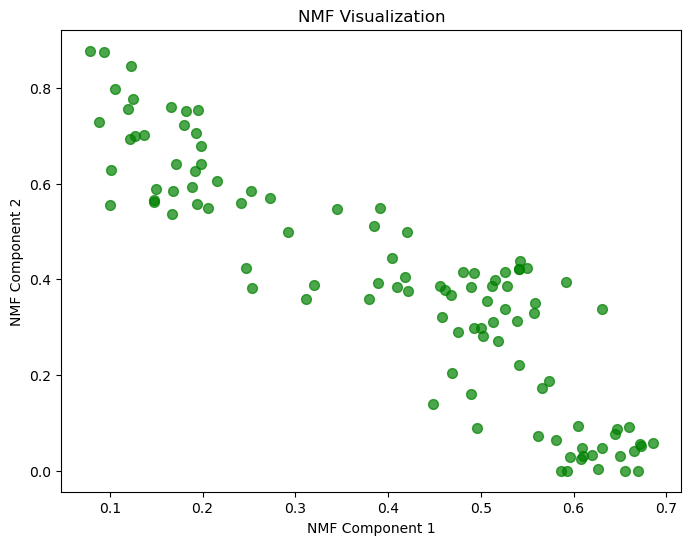

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(nmf_df['NMF1'], nmf_df['NMF2'], c='green', s=50, alpha=0.7)
plt.title('NMF Visualization')
plt.xlabel('NMF Component 1')
plt.ylabel('NMF Component 2')
plt.show()

In [ ]:
X_nmf = nmf_df.copy()

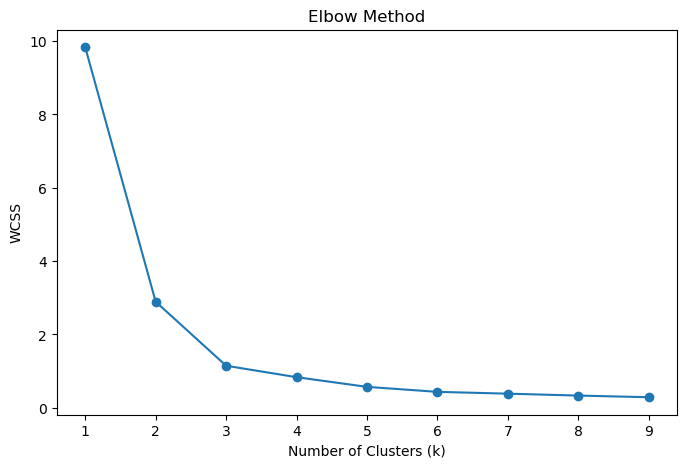

In [ ]:
plot_elbow(X_nmf, r=range(1,10))

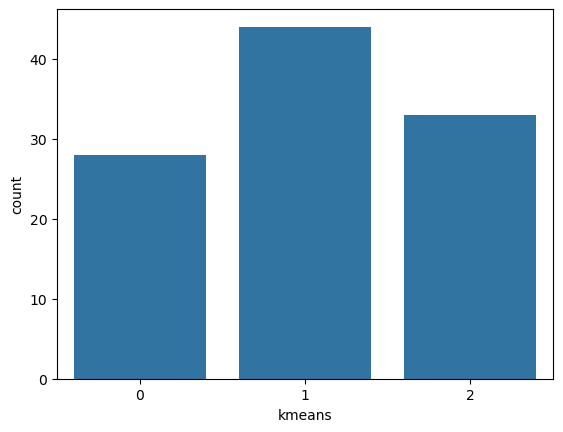

In [ ]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(X_nmf)
labels = kmeans.predict(X_nmf)
nmf_df['kmeans'] = labels
sns.countplot(data=nmf_df, x=nmf_df['kmeans'])
plt.show()

In [ ]:
# Compute the linkage matrix
linkage_matrix = linkage(X_nmf, method='ward')

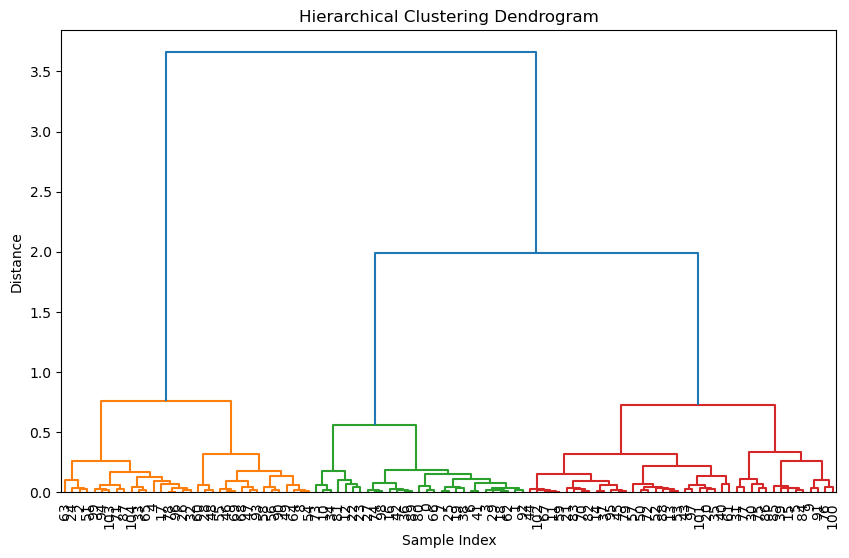

In [ ]:
plot_dendrogram(linkage_matrix)

In [ ]:
# Assign cluster labels (specify the number of clusters)
num_clusters = 3
cluster_labels = fcluster(linkage_matrix, num_clusters, criterion='maxclust')

# Add cluster labels to the DataFrame
nmf_df['HC'] = cluster_labels - 1
print(nmf_df)

                NMF1      NMF2  kmeans  HC
file_name                                 
m00003.wav  0.581037  0.063536       0   1
m00012.wav  0.609281  0.048412       0   1
m00013.wav  0.272986  0.568964       2   0
m00043.wav  0.596080  0.029358       0   1
m00044.wav  0.101551  0.628156       2   0
...              ...       ...     ...  ..
m00971.wav  0.247216  0.422767       1   2
m00973.wav  0.538614  0.313237       1   2
m00988.wav  0.542343  0.438847       1   2
m00991.wav  0.192185  0.625591       2   0
m00995.wav  0.167195  0.536567       2   0

[105 rows x 4 columns]


In [ ]:
spectral = SpectralClustering(n_clusters=3, affinity='nearest_neighbors', n_neighbors=15)
spectral_labels = spectral.fit_predict(X_nmf)
nmf_df['spectral'] = spectral_labels

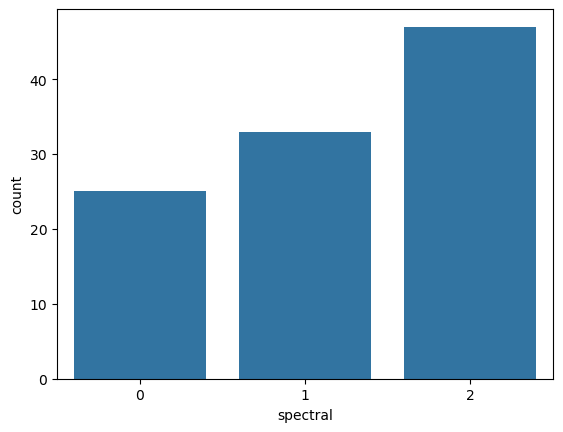

In [ ]:
sns.countplot(data=nmf_df, x=nmf_df['spectral'])
plt.show()

In [ ]:
display(nmf_df)

,NMF1,NMF2,kmeans,HC,spectral
file_name,,,,,
m00003.wav,0.581037,0.063536,0,1,0
m00012.wav,0.609281,0.048412,0,1,0
m00013.wav,0.272986,0.568964,2,0,1
m00043.wav,0.596080,0.029358,0,1,0
m00044.wav,0.101551,0.628156,2,0,1
...,...,...,...,...,...
m00971.wav,0.247216,0.422767,1,2,2
m00973.wav,0.538614,0.313237,1,2,2
m00988.wav,0.542343,0.438847,1,2,2


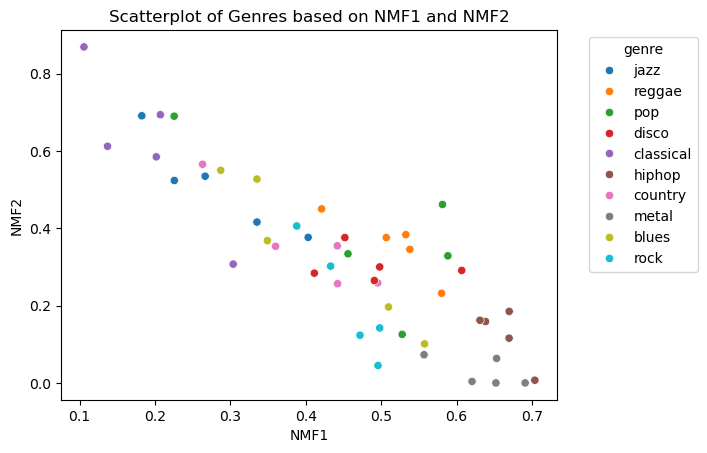

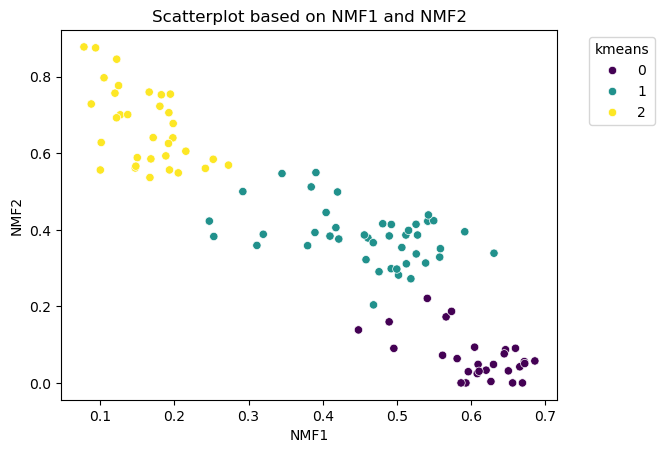

In [ ]:
scatterplot(data=nmf_labeled, x='NMF1', y='NMF2', hue='genre', palette=None, title='Scatterplot of Genres based on NMF1 and NMF2')
scatterplot(data=nmf_df, x='NMF1', y='NMF2', hue='kmeans', title='Scatterplot based on NMF1 and NMF2')

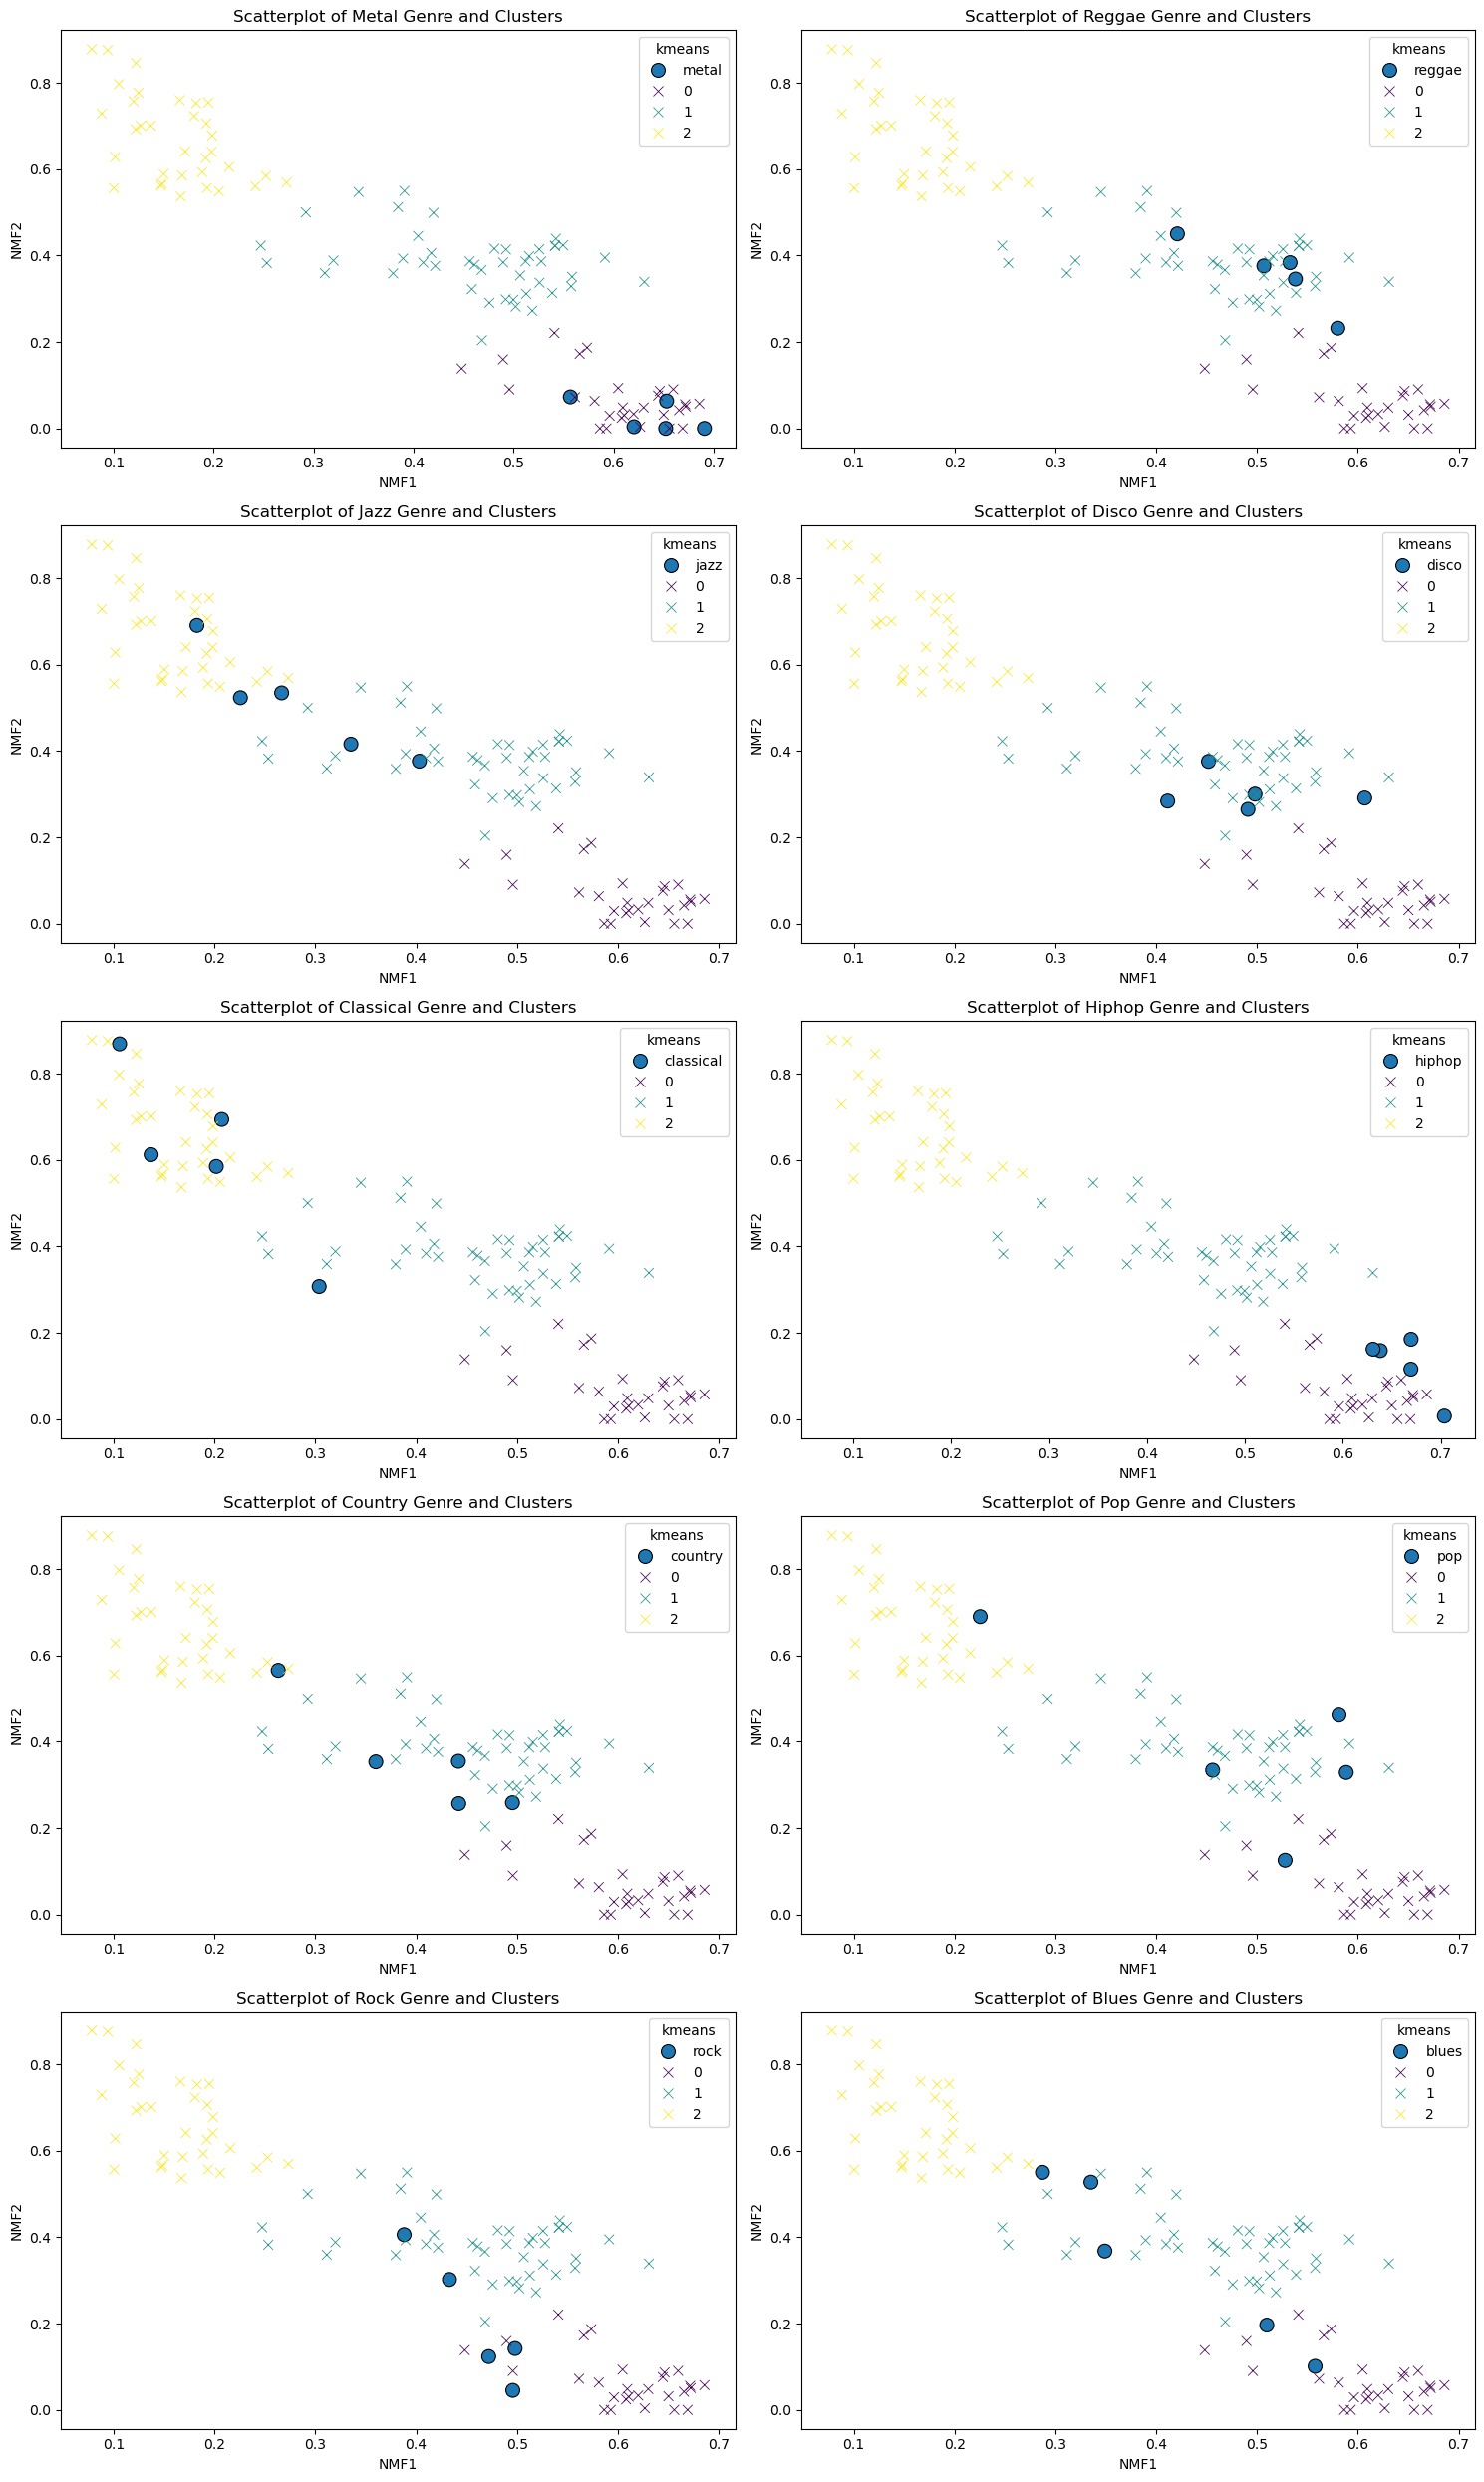

In [ ]:
compare_labels(labeled_data=nmf_labeled, unlabeled_data=nmf_df, x='NMF1', y='NMF2')

|kmeans|Labels|
|------|------|
|0     |Pop   |
|1     |Metal |
|2     |Classical|

In [ ]:
genre_mapping = {0: 'pop', 1: 'metal', 2: 'classical'}
nmf_df['genre'] = nmf_df['kmeans'].map(genre_mapping)
display(nmf_df.head(10))

,NMF1,NMF2,kmeans,HC,spectral,genre
file_name,,,,,,
m00003.wav,0.581037,0.063536,0,1,0,pop
m00012.wav,0.609281,0.048412,0,1,0,pop
m00013.wav,0.272986,0.568964,2,0,1,classical
m00043.wav,0.596080,0.029358,0,1,0,pop
m00044.wav,0.101551,0.628156,2,0,1,classical
m00055.wav,0.421599,0.375935,1,2,2,metal
m00061.wav,0.592905,0.000000,0,1,0,pop
m00063.wav,0.669031,0.000000,0,1,0,pop
m00069.wav,0.127200,0.700498,2,0,1,classical


## Results

In [ ]:
def submission(dataframe, cluster_col='', file_name='submission'):
    df = dataframe.copy()
    sub = df[cluster_col].reset_index()
    sub.rename(columns={'file_name': 'filename'}, inplace=True)
    
    os.makedirs('predictions', exist_ok=True)

    csv_file = f'predictions/{file_name}.csv'
    sub.to_csv(csv_file, index=False)
    print(f'Submission saved to {csv_file}')

In [ ]:
submission(unlabeled_data, cluster_col='genre', file_name='unlabeled_data')

Submission saved to predictions/unlabeled_data.csv


De kaggle scores die hieronder genoteerd worden zijn de beste score die we hebben gekregen met de dataframe waarop we clustering hebben uitgevoerd. Uit welk clustering model kan verschillen, en uit aantal tests is er geen groot verschil in de resultaten tussen de cluster modellen. We kiezen dan ervoor om het simpel te houden en meer naar de features te kijken, vandaar we alleen per dataframe de score noteren en niet per model.

|DataFrame|Kaggle Score|
|---------|------------|
|unlabeled_data (all features/no reduction)|0.96|
|pca_df (PCA)|0.96|
|nmf_df (NMF)|None|

## Conclusion & Advice

## Sources

- GeeksforGeeks. (2023, 14 december). Spectral Clustering: A Comprehensive Guide for Beginners. GeeksforGeeks. https://www.geeksforgeeks.org/spectral-clustering-a-comprehensive-guide-for-beginners/

- mlres.net. (2024, 7 februari). Foundations of Spectral Clustering: From Basics to Algorithms. Neural Nexus. https://mlres.net/foundations-of-spectral-clustering-from-basics-to-algorithms/#:~:text=In%20summary%2C%20the%20mathematics%20behind%20spectral%20clustering%E2%80%94centered%20around,of%20the%20data%20and%20reveal%20its%20underlying%20structure.

- Uniyal, M. (2024, 18 oktober). Hierarchical clustering in machine learning. Applied AI Blog. https://www.appliedaicourse.com/blog/hierarchical-clustering-in-machine-learning/

- Gupta, B. (2022, 16 november). Hierarchical clustering in machine learning- Scaler topics. Scaler Topics. https://www.scaler.com/topics/machine-learning/hierarchical-clustering/

- Wikipedia contributors. (2024, 12 december). Principal Component Analysis. Wikipedia. https://en.wikipedia.org/wiki/Principal_component_analysis

- GeeksforGeeks. (2024, 17 september). Principal Component Analysis (PCA). GeeksforGeeks. https://www.geeksforgeeks.org/principal-component-analysis-pca/

- Wikipedia contributors. (2024, 12 december). Non-negative Matrix Factorization. Wikipedia. https://en.wikipedia.org/wiki/Non-negative_matrix_factorization

- Lee, D. D., & Seung, H. S. (2001). Algorithms for Non-negative Matrix Factorization. Advances in Neural Information Processing Systems, 13, 556–562. https://proceedings.neurips.cc/paper/1861-algorithms-for-non-negative-matrix-factorization.pdf

- GeeksforGeeks. (2024, 17 september). Introduction to Non-negative Matrix Factorization. GeeksforGeeks. https://www.geeksforgeeks.org/introduction-to-non-negative-matrix-factorization/

- Wikipedia contributors. (2024, 27 november). K-means clustering. https://en.wikipedia.org/wiki/K-means_clustering

- Sahani, G. R. (2024, 15 januari). Euclidean and Manhattan distance metrics in Machine Learning. Medium. https://medium.com/analytics-vidhya/euclidean-and-manhattan-distance-metrics-in-machine-learning-a5942a8c9f2f

- GeeksforGeeks. (2024, 29 augustus). K means Clustering Introduction. GeeksforGeeks. https://www.geeksforgeeks.org/k-means-clustering-introduction/

- Ogbeide, J. (2024, 14 november). “Understanding Inertia, Distortion, and Silhouette Scores and their differences: Key Metrics for Effective Clustering Analysis”. Medium. https://medium.com/@jeffzyme/understanding-inertia-distortion-and-silhouette-scores-and-their-differences-key-metrics-for-458fe28ce2aa

- Mahendru, K. (2025, 3 januari). How to Determine the Optimal K for K-Means? - Analytics Vidhya - Medium. Medium. https://medium.com/analytics-vidhya/how-to-determine-the-optimal-k-for-k-means-708505d204eb

- GeeksforGeeks. (2024, 26 juni). Melfrequency Cepstral Coefficients (MFCC) for Speech Recognition. GeeksforGeeks. https://www.geeksforgeeks.org/mel-frequency-cepstral-coefficients-mfcc-for-speech-recognition/?ref=gcse_outind

- Wikipedia contributors. (2024, 28 november). Chroma feature. Wikipedia. https://en.wikipedia.org/wiki/Chroma_feature

